# dots measurement at Subaru (20210710) (for only 1 visit to check)

In [1]:
import pandas as pd
import sep
import cv2
from copy import deepcopy

import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import math

In [2]:
def rotatePoint2(coord, ori, angle):
    """Only rotate a point around the origin (0, 0)."""
    radians = np.deg2rad(angle)
    x = coord[0] - ori[0]
    y = coord[1] - ori[1]
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)
    
    return xx+ori[0], yy+ori[1]

## rotator angle = 0 deg., EL = 90 deg.

### designed dots infomation

In [3]:
fel=pd.read_csv('/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/dot_pos_final.txt', sep = '\s+')

In [4]:
fel

id        x_mm   y_mm            x            y           bb  \
0        0   96.994843    0.0  5614.759176  2886.225955  5614.759277   
1        1  103.923042    4.0  5695.685201  2932.765529  5695.393555   
2        2  110.851250    8.0  5776.593112  2979.286068  5776.393066   
3        3  117.779450   12.0  5857.156087  3025.757010  5857.078613   
4        4  124.707657   16.0  5937.719843  3072.196818  5937.756348   
...    ...         ...    ...          ...          ...          ...   
2389  2389  -41.569214   80.0  3996.636351  3826.956730  3996.431152   
2390  2390  -55.425613   88.0  3834.981196  3920.772418  3834.983154   
2391  2391  -69.282028   96.0  3673.712751  4014.114572  3673.579834   
2392  2392  -83.138428  104.0  3512.717930  4107.249548  3512.585449   
2393  2393  -96.994843  112.0  3351.929391  4200.277400  3351.910400   

               cc  
0     2886.101562  
1     2932.880127  
2     2979.337891  
3     3025.395508  
4     3072.048340  
...           ...  
2389  3826.726807  
2390  3919.957031  
2391  4013.147461  
2392  4106.453613  
2393  4199.188965  

[2394 rows x 7 columns]

## observed data

In [6]:
#file='/work/PFS/pfi/data/asrd_mhs_raw_data/2021-04-28/PFSC21642200.fits'
#file='/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/2021-07-09/PFSC22583000.fits'
file='/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/2021-07-10/PFSC22589000.fits'

f =pyfits.open(file)
data=f[1].data

### transformation for initial guess (you need to do this carefully)

In [9]:
## very rough estimate ##
x_shift = 3838
y_shift = 3517
x_scale = 13.3
y_scale = 13.3
rot = 0.0
xx=(fel['x_mm'].values.astype(float)*x_scale)+x_shift
yy=(fel['y_mm'].values.astype(float)*y_scale)+y_shift
rx,ry=rotatePoint2([xx,yy],[x_shift,y_shift], rot)

<IPython.core.display.Javascript object>


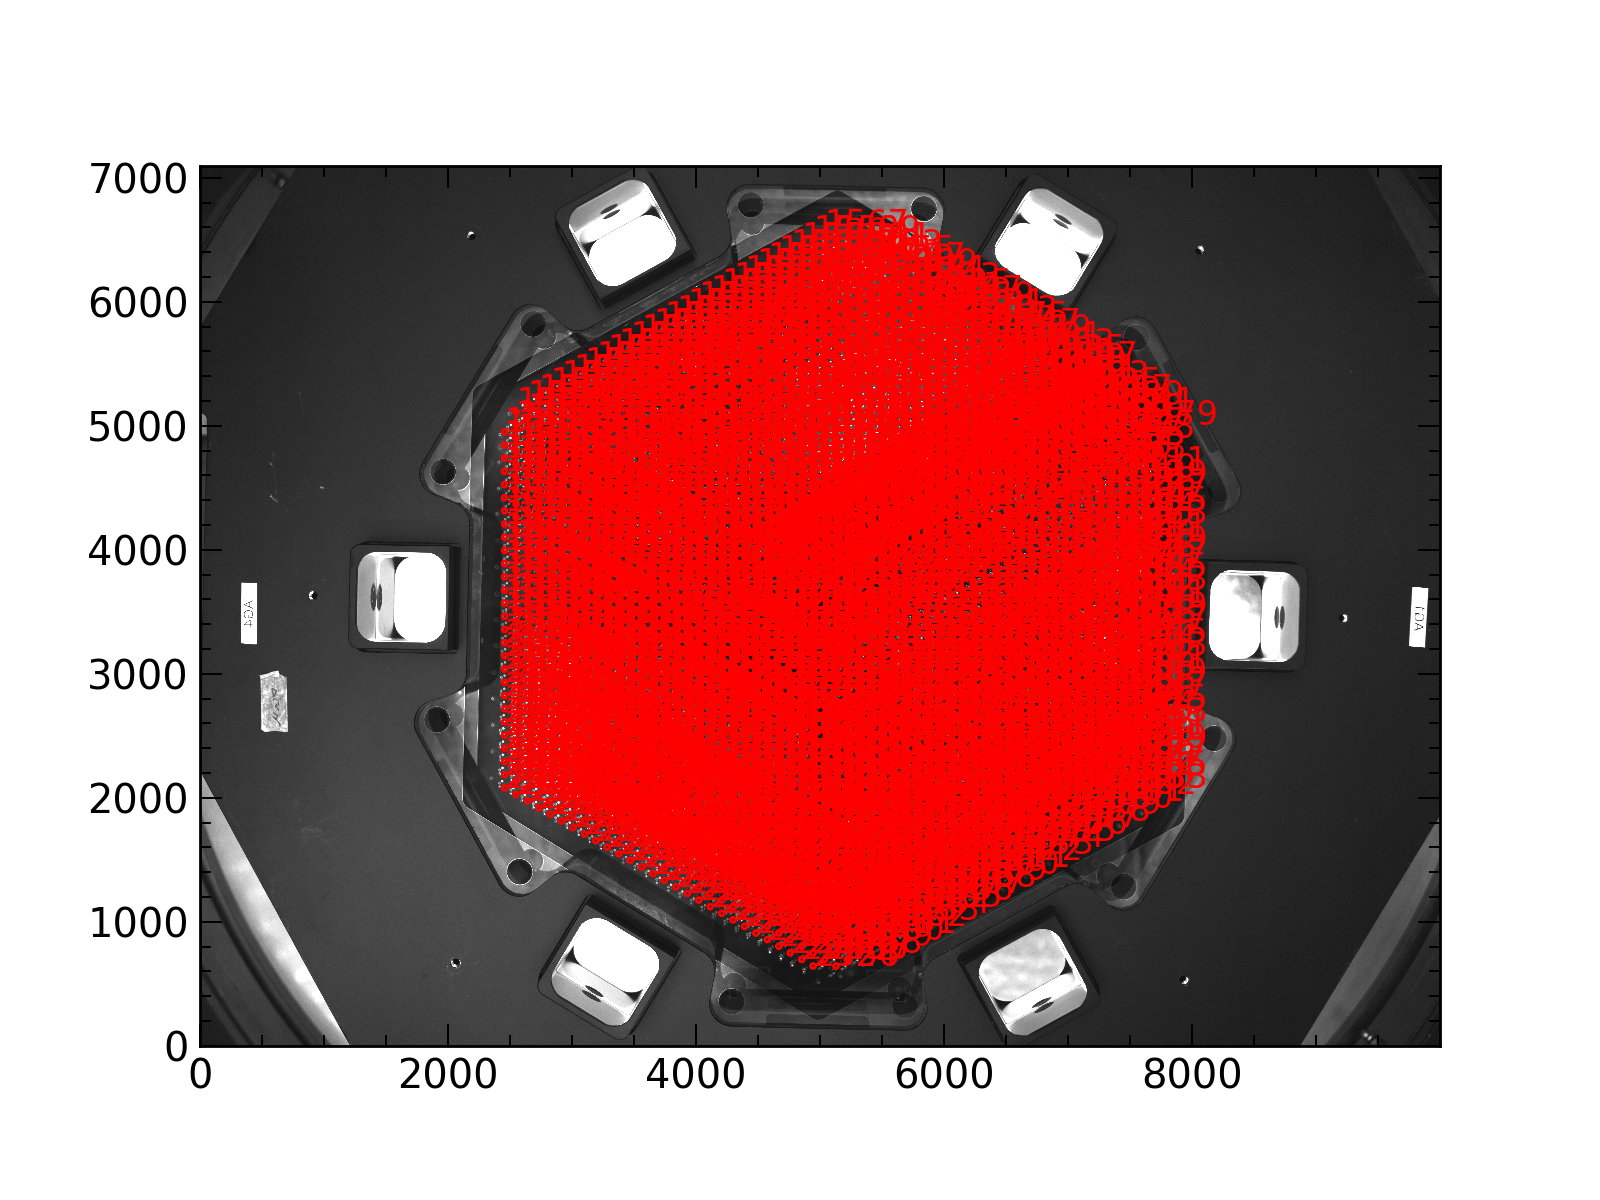

In [10]:
%matplotlib notebook

m, s = np.mean(data), np.std(data)

fig, ax = plt.subplots(figsize=(8,6))

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')


for i in range(len(rx)):
    c = plt.Circle((rx[i], ry[i]), 20, color='red', fill=False)
    ax.add_artist(c)
    ax.text(rx[i], ry[i], '%d' % (fel['id'][i]), color='red')
    
plt.show()

In [11]:
## choose different points (should be spreaded over entire field)
id_sel = [1567, 2351, 783, 785]
x_mcs_sel = [5123, 2436, 7606, 5149]
y_mcs_sel = [6545, 2136, 2009, 3722]
x_pfi_sel = list(fel.loc[id_sel]['x_mm'])
y_pfi_sel = list(fel.loc[id_sel]['y_mm'])

In [12]:
pts1=np.zeros((1,len(id_sel),2))
pts2=np.zeros((1,len(id_sel),2))
pts1[0,:,0]=x_pfi_sel
pts1[0,:,1]=y_pfi_sel
pts2[0,:,0]=x_mcs_sel
pts2[0,:,1]=y_mcs_sel

afCoeff,inlier=cv2.estimateAffinePartial2D(pts1, pts2)
inlier=inlier.reshape(len(inlier))

M={}
M['affineCoeff'] = afCoeff
M['xTrans']=afCoeff[0,2]
M['yTrans']=afCoeff[1,2]
M['xScale']=np.sqrt(afCoeff[0,0]**2+afCoeff[0,1]**2)
M['yScale']=np.sqrt(afCoeff[1,0]**2+afCoeff[1,1]**2)
M['angle']=np.arctan2(afCoeff[1,0]/np.sqrt(afCoeff[0,0]**2+afCoeff[0,1]**2), afCoeff[1,1]/np.sqrt(afCoeff[1,0]**2+afCoeff[1,1]**2))

In [13]:
pts=np.zeros((1,len(fel),2))
pts[0,:,0]=fel['x_mm']
pts[0,:,1]=fel['y_mm']
afCor=cv2.transform(pts, M['affineCoeff'])
rx=afCor[0,:,0]
ry=afCor[0,:,1]

In [14]:
M

{'affineCoeff': array([[ 1.33050687e+01,  3.15740125e-01,  3.85296555e+03],
        [-3.15740125e-01,  1.33050687e+01,  3.53992027e+03]]),
 'xTrans': 3852.9655503382896,
 'yTrans': 3539.92026835819,
 'xScale': 13.308814514490564,
 'yScale': 13.308814514490564,
 'angle': -0.023726361964649043}

<IPython.core.display.Javascript object>


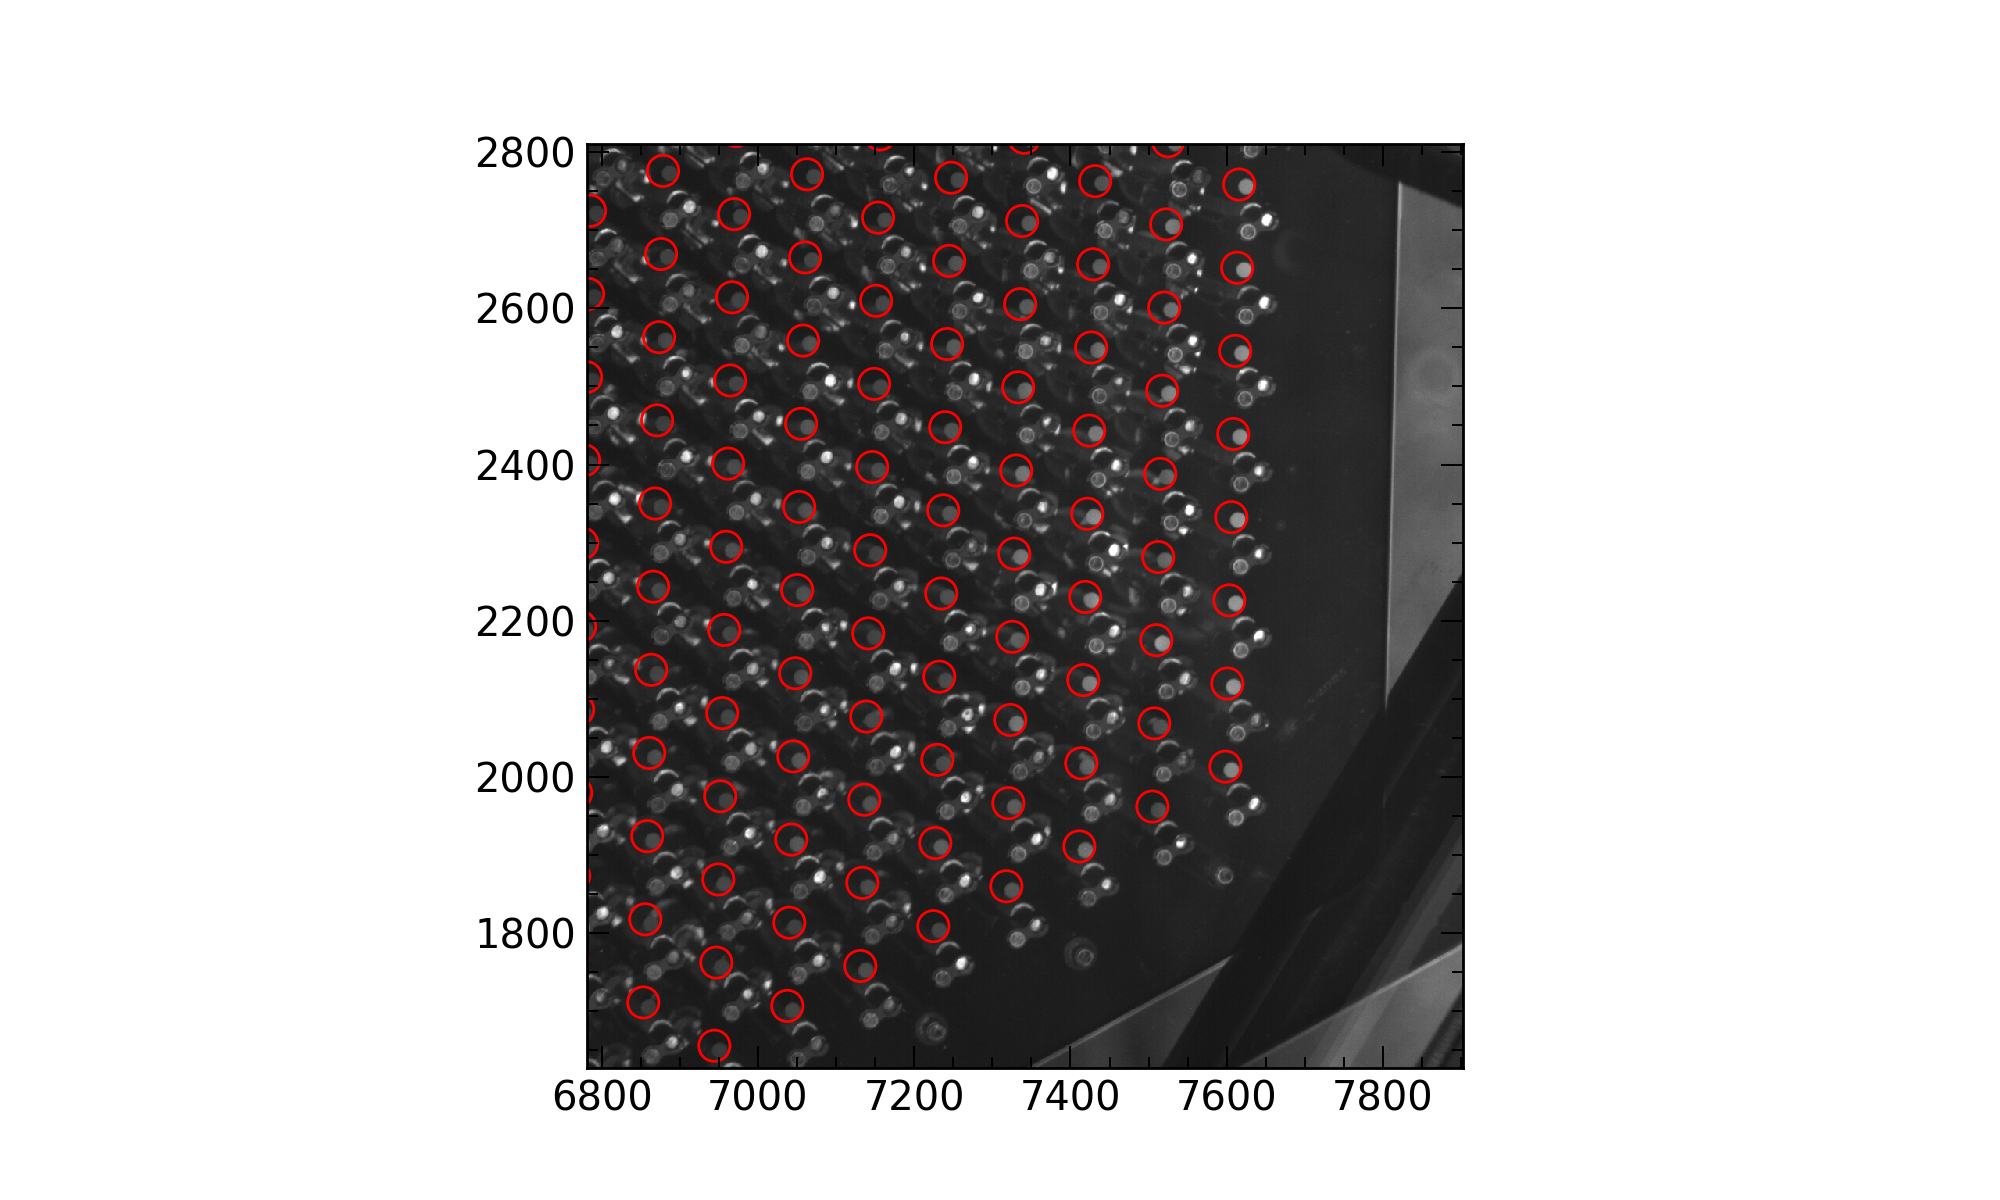

In [15]:
%matplotlib notebook
m, s = np.mean(data), np.std(data)

fig, ax = plt.subplots(figsize=(10,6))

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')


for i in range(len(rx)):
    c = plt.Circle((rx[i], ry[i]), 20, color='red', fill=False)
    ax.add_artist(c)
    #ax.text(rx[i], ry[i], '%d' % (fel['id'][i]), color='red')

plt.show()

### data region trimming

<IPython.core.display.Javascript object>


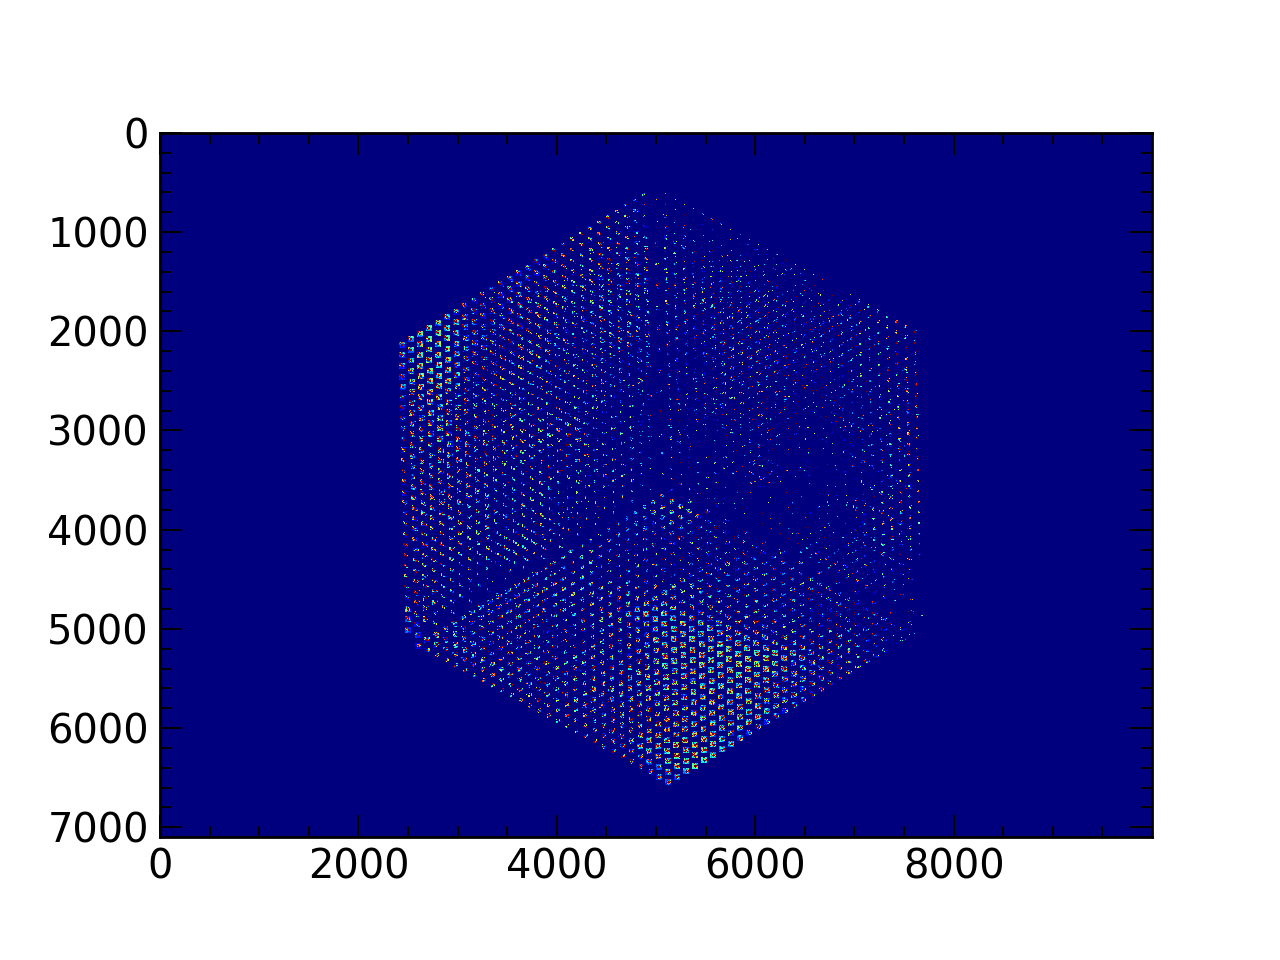

In [17]:
%matplotlib notebook

reg=30
thresh=3000

v_med =  np.median(data)
imag_new = np.zeros(data.shape) + v_med
#imag_new = np.zeros(data.shape)

for xd, yd in zip(rx, ry):
    x1 = int(xd - reg)
    x2 = int(xd + reg)
    y1 = int(yd - reg)
    y2 = int(yd + reg)
    imag_new[y1:y2, x1:x2] = data[y1:y2, x1:x2]
    
imag_new[imag_new > thresh] = v_med

plt.imshow(imag_new, vmin=400, vmax=1000)
#plt.imshow(imag_new, vmin=0, vmax=1500)

### get rough brightness gradient (we may not need this...)

In [15]:
#import scipy.ndimage as nd
#gauss_sigma = 50
#imag_flt = nd.gaussian_filter(imag_new, sigma=gauss_sigma)

In [16]:
#imag_flt2 = imag_flt / np.median(imag_flt)

In [17]:
#%matplotlib notebook

#plt.imshow(imag_flt2, vmin=0.9, vmax=1.1)

In [18]:
#imag_new_flt = imag_new / imag_flt2

In [19]:
#%matplotlib notebook
#plt.imshow(imag_new)

### get dot positions

In [18]:
reg=20

bad_idx = []
dot_pos = []
for i in range(len(rx)):
    #data_sub=imag_new_flt[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
    data_sub=imag_new[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
    imag_sub=deepcopy(data_sub)
    imag_sub = 255 * imag_sub / imag_sub.max()

    circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                               param1=50,param2=8,minRadius=6,maxRadius=12)

    if circles is not None:
        dot_x = int(rx[i]-reg)+circles[0,0,0]
        dot_y = int(ry[i]-reg)+circles[0,0,1]
        dot_r = circles[0,0,2]
        dot_pos.append((dot_x, dot_y, dot_r))
    else:
        bad_idx.append(i)
        dot_pos.append((np.nan, np.nan, np.nan))
        print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')
        
dot_pos = np.array(dot_pos)

 dota id 1569 at 4868.210927824912 3569.077913689371 detection failed
 dota id 1826 at 4390.891319847086 2888.151902863178 detection failed
 dota id 2355 at 5034.889929968116 2819.61904518639 detection failed


<IPython.core.display.Javascript object>


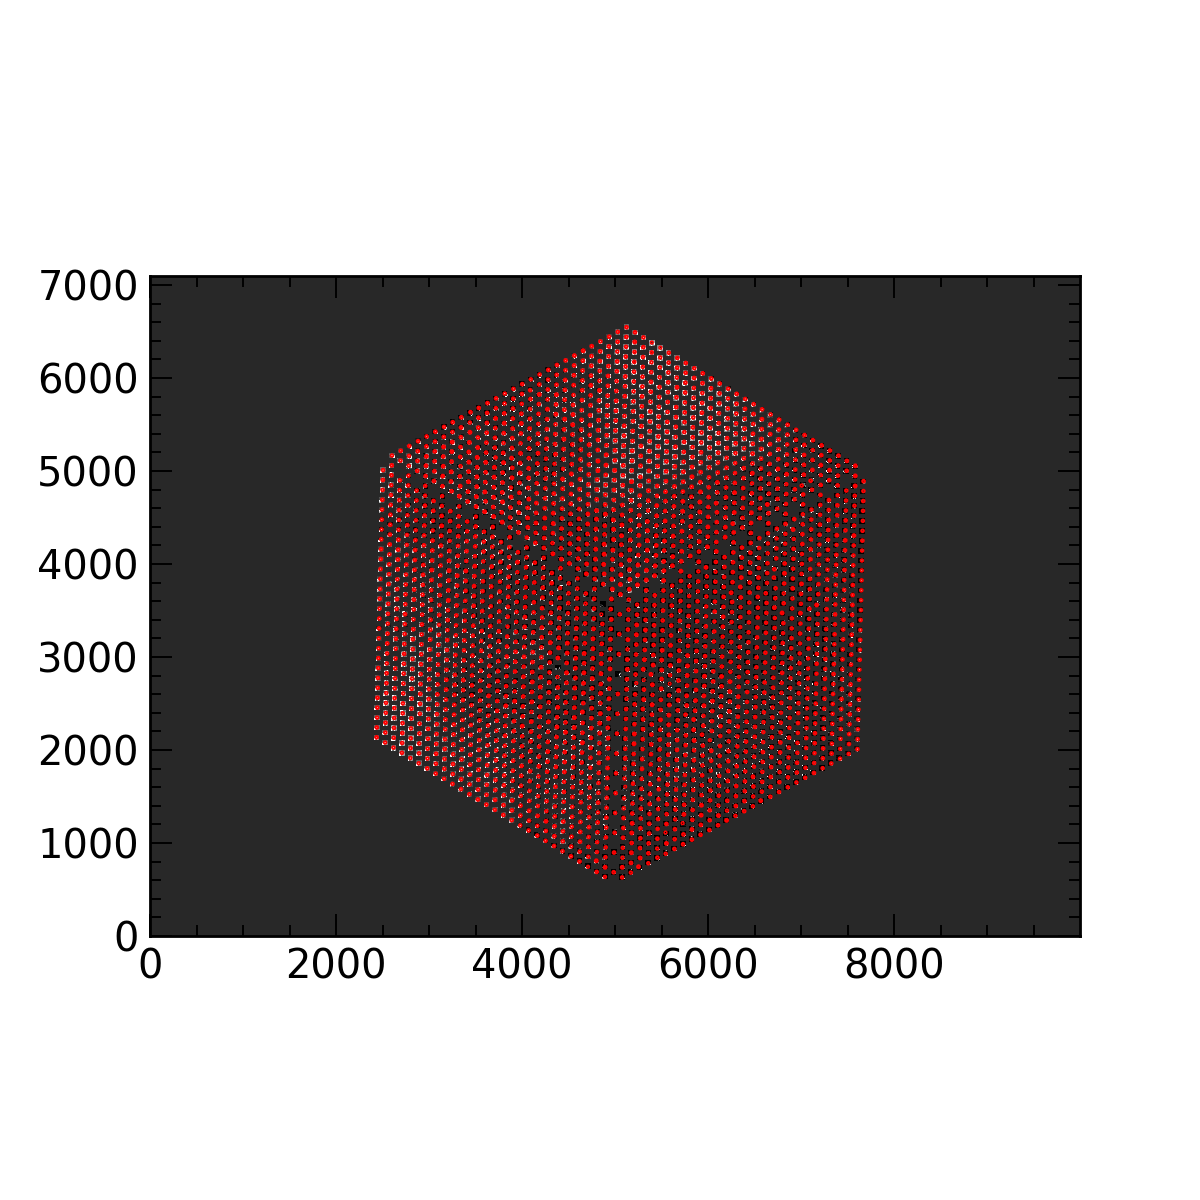

In [19]:
%matplotlib notebook
#m, s = np.mean(data), np.std(data)
m, s = 400, 200

fig, ax = plt.subplots(figsize=(6,6))

#im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
#im = ax.imshow(imag_new_flt, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
im = ax.imshow(imag_new, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for p in dot_pos:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
    
plt.show()

### get transformation coefficients (including distortion)

In [20]:
pts0=np.zeros((1,len(fel),3))
pts0[0,:,0]=fel['x_mm']
pts0[0,:,1]=fel['y_mm']
pts0[0,:,2]=[0 for x in fel['x_mm']]
pts1=np.zeros((1,len(fel),3))
pts2=np.zeros((1,len(fel),2))
pts1[0,:,0]=fel['x_mm']
pts1[0,:,1]=fel['y_mm']
pts1[0,:,2]=[0 for x in fel['x_mm']]
pts2[0,:,0]=dot_pos[:,0]
pts2[0,:,1]=dot_pos[:,1]

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

In [21]:
for i in np.sort(bad_idx)[::-1]:
    pts1 = np.delete(pts1, i, 1)
    pts2 = np.delete(pts2, i, 1)    

In [22]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)

In [23]:
for i in range(len(pts0)):
    imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

In [24]:
dot_pos_new = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_pos[:,2])])

In [25]:
dot_pos_new

array([[5144.6543, 3509.081 ,    9.6   ],
       [5238.5146, 3560.3499,    9.1   ],
       [5332.374 , 3611.619 ,   10.    ],
       ...,
       [2960.5283, 4839.694 ,    9.6   ],
       [2779.8142, 4949.7676,    9.6   ],
       [2599.3813, 5059.6724,   10.3   ]], dtype=float32)

<IPython.core.display.Javascript object>


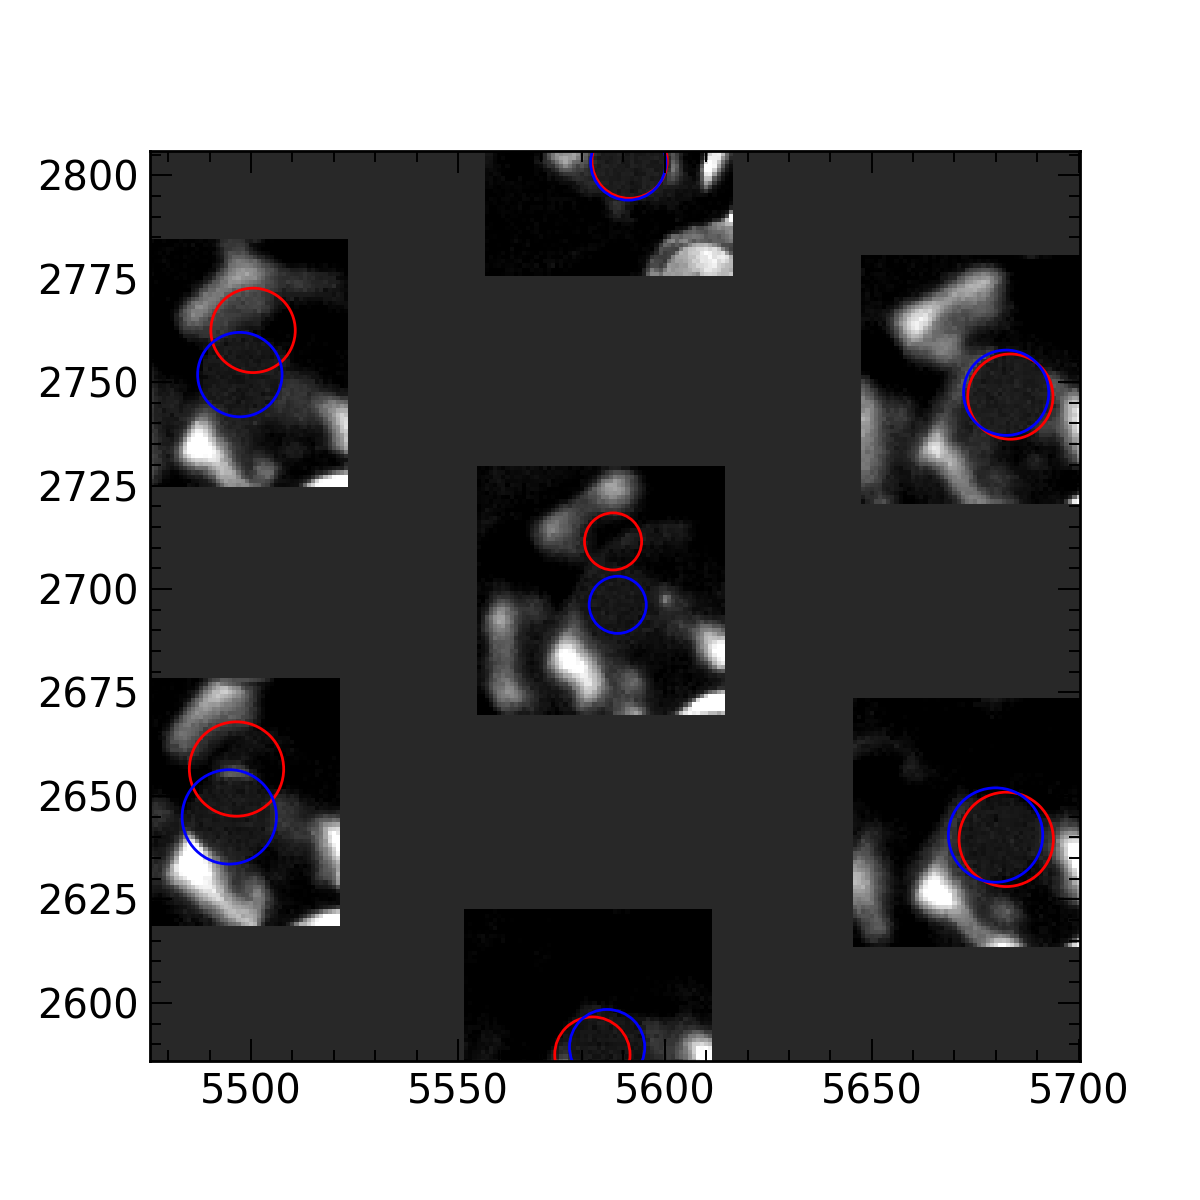

In [26]:
%matplotlib notebook
#m, s = np.mean(data), np.std(data)
m, s = 400, 200

fig, ax = plt.subplots(figsize=(6,6))

#im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
im = ax.imshow(imag_new, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for p in dot_pos:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
for p in dot_pos_new:
    c = plt.Circle((p[0], p[1]), p[2], color='blue', fill=False)
    ax.add_artist(c)
    
plt.show()

### data region triming (2nd pass)

In [27]:
rx2 = dot_pos_new[:,0]
ry2 = dot_pos_new[:,1]

In [28]:
dot_pos_new

array([[5144.6543, 3509.081 ,    9.6   ],
       [5238.5146, 3560.3499,    9.1   ],
       [5332.374 , 3611.619 ,   10.    ],
       ...,
       [2960.5283, 4839.694 ,    9.6   ],
       [2779.8142, 4949.7676,    9.6   ],
       [2599.3813, 5059.6724,   10.3   ]], dtype=float32)

<IPython.core.display.Javascript object>


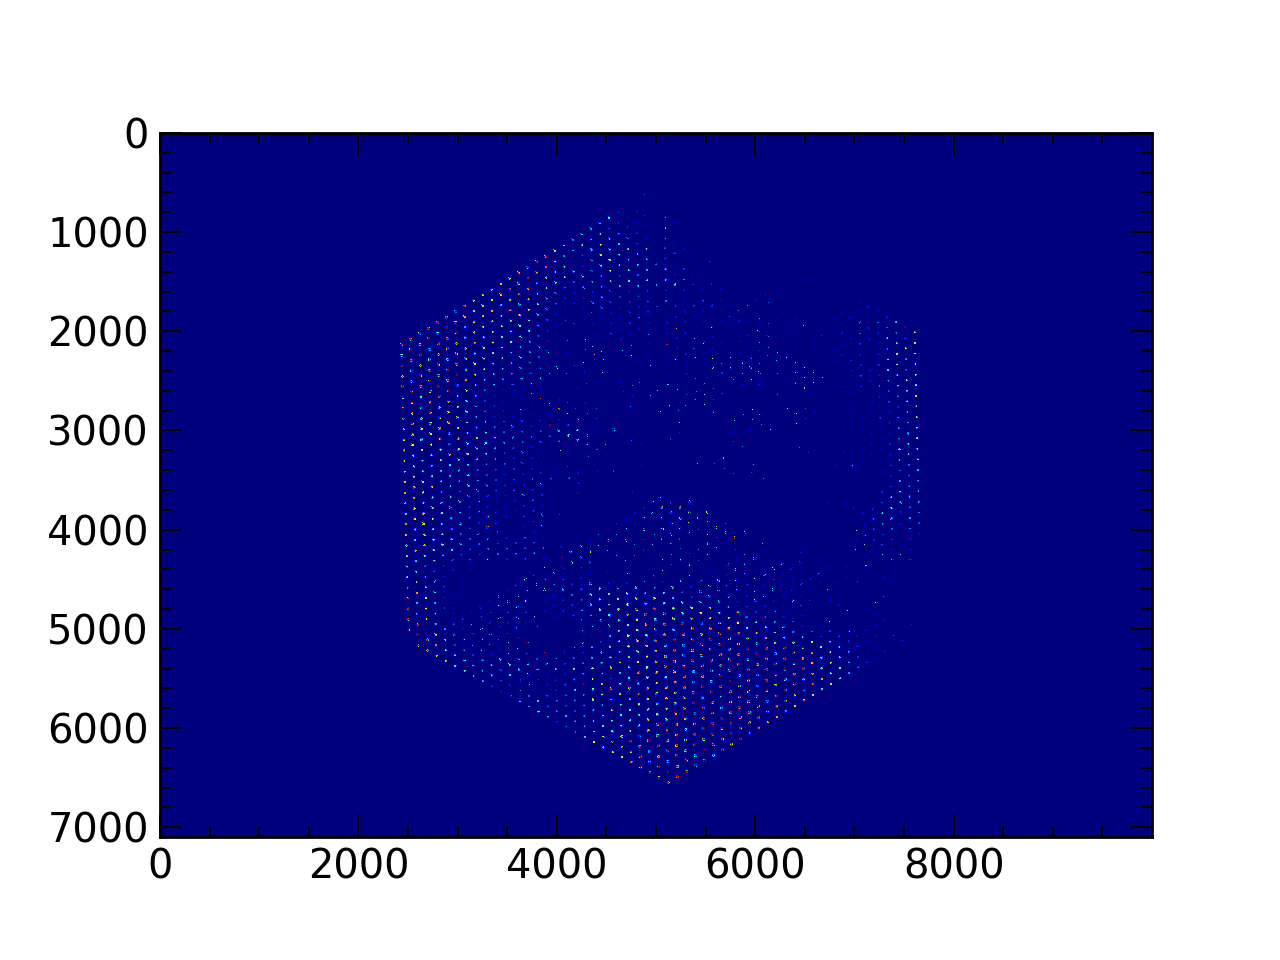

In [30]:
%matplotlib notebook

reg=15
thresh=3000

v_med =  np.median(data)
imag_new2 = np.zeros(data.shape) + v_med

for xd, yd in zip(rx2, ry2):
    x1 = int(xd - reg)
    x2 = int(xd + reg)
    y1 = int(yd - reg)
    y2 = int(yd + reg)
    imag_new2[y1:y2, x1:x2] = data[y1:y2, x1:x2]
    
imag_new2[imag_new2 > thresh] = v_med

plt.imshow(imag_new2, vmin=400, vmax=2000)

### get dot positions (2nd pass)

In [32]:
reg=15

imag_new2_disp = deepcopy(imag_new2)

bad_idx = []
dot_pos2 = []
for i in range(len(rx2)):
    data_sub=imag_new2[int(ry2[i]-reg):int(ry2[i]+reg),int(rx2[i]-reg):int(rx2[i]+reg)]
    imag_sub=deepcopy(data_sub)
    #val_cnt = np.nanmedian(imag_sub[int(0.7*reg):int(1.3*reg), int(0.7*reg):int(1.3*reg)])
    #imag_sub[imag_sub>2.0*val_cnt] = 0.0
    #imag_sub[imag_sub<0.5*val_cnt] = 0.0
    imag_sub = 255 * imag_sub / imag_sub.max()

    imag_new2_disp[int(ry2[i]-reg):int(ry2[i]+reg),int(rx2[i]-reg):int(rx2[i]+reg)] = imag_sub
    
    circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50,param2=5,minRadius=9,maxRadius=12)

    if circles is not None:
        dot_x = int(rx2[i]-reg) + circles[0,0,0]
        dot_y = int(ry2[i]-reg) + circles[0,0,1]
        dot_r = circles[0,0,2]
        dot_pos2.append((dot_x, dot_y, dot_r))
    else:
        bad_idx.append(i)
        dot_pos2.append((np.nan, np.nan, np.nan))
        print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')

dot_pos2 = np.array(dot_pos2)

<IPython.core.display.Javascript object>


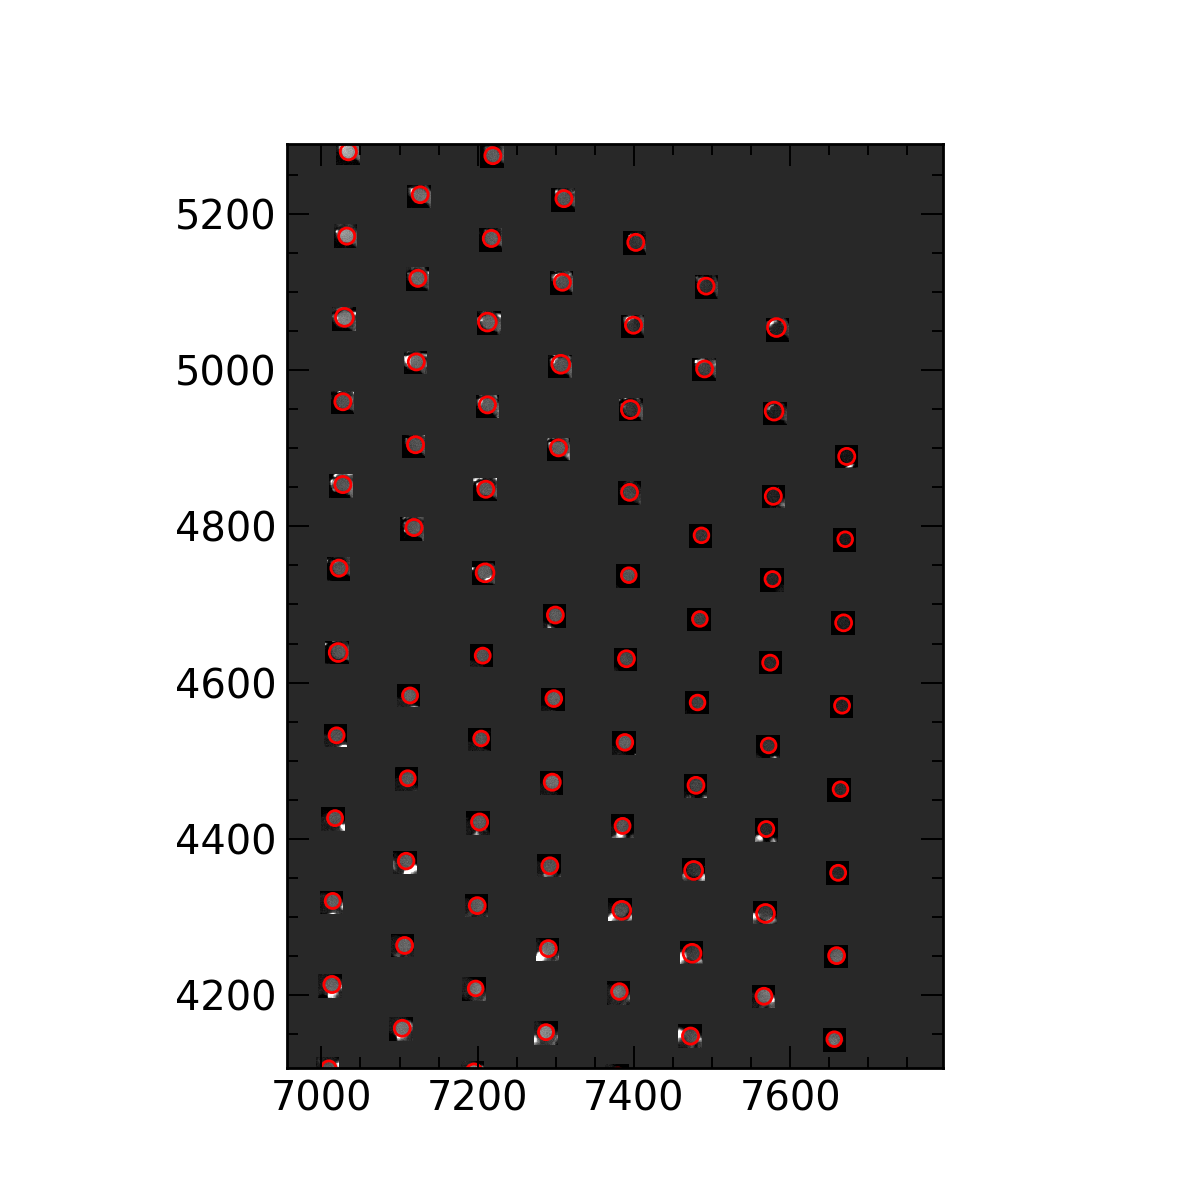

In [33]:
%matplotlib notebook
m, s = 400, 200

fig, ax = plt.subplots(figsize=(6,6))

im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
#im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=0, vmax=255, origin='lower')

for p in dot_pos2:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
    
plt.show()

### get transformation coefficients (2nd pass)

In [34]:
pts0=np.zeros((1,len(fel),3))
pts0[0,:,0]=fel['x_mm']
pts0[0,:,1]=fel['y_mm']
pts0[0,:,2]=[0 for x in fel['x_mm']]
pts1=np.zeros((1,len(fel),3))
pts2=np.zeros((1,len(fel),2))
pts1[0,:,0]=fel['x_mm']
pts1[0,:,1]=fel['y_mm']
pts1[0,:,2]=[0 for x in fel['x_mm']]
pts2[0,:,0]=dot_pos2[:,0]
pts2[0,:,1]=dot_pos2[:,1]

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

In [35]:
for i in bad_idx:
    pts1 = np.delete(pts1, i, 1)
    pts2 = np.delete(pts2, i, 1)    

In [36]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)

In [37]:
## calculate dot position ##
for i in range(len(pts0)):
    imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

In [38]:
## calculate dot radius ##
pts0d = deepcopy(pts0)
pts0d[0,:,0] = pts0d[0,:,0] + 1.5

for i in range(len(pts0)):
    tmp1, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)
for i in range(len(pts0d)):
    tmp2, _ = cv2.projectPoints(pts0d[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

dot_rad = (tmp2[:,0,0] - tmp1[:,0,0]) / 2.0

In [39]:
dot_pos_new2 = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_rad[:])])

<IPython.core.display.Javascript object>


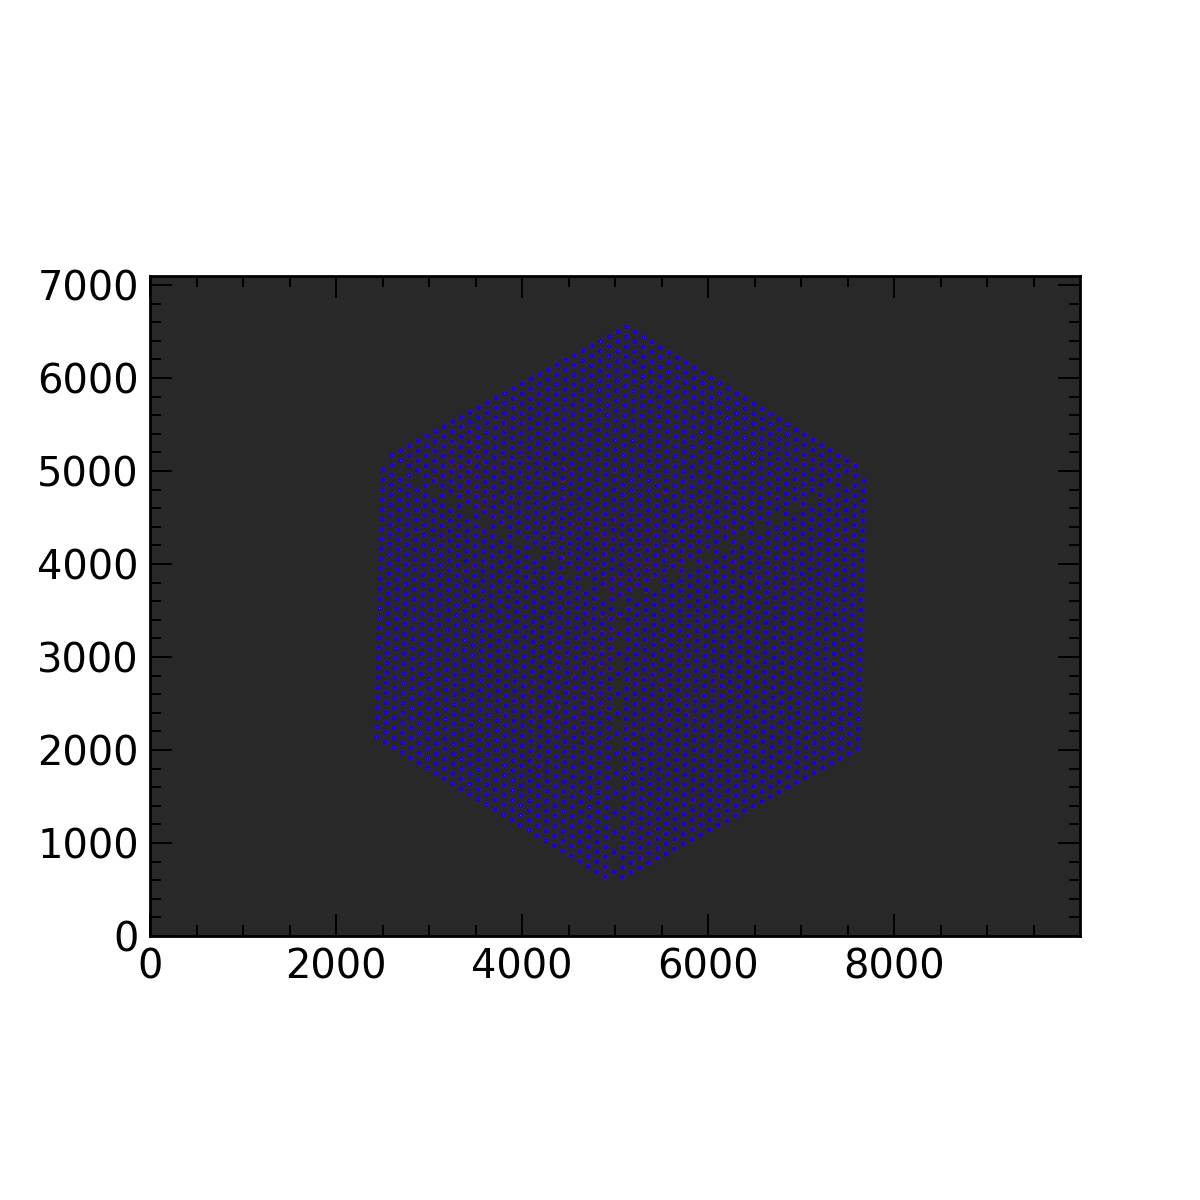

In [40]:
%matplotlib notebook
#m, s = np.mean(data), np.std(data)
m, s = 400, 200

fig, ax = plt.subplots(figsize=(6,6))

#im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for p in dot_pos2:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
for i,p in enumerate(dot_pos_new2):
    #if inlier[i]==1:
    c = plt.Circle((p[0], p[1]), p[2], color='blue', fill=False)
    ax.add_artist(c)

plt.show()

## write to file

In [41]:
dot_id = np.arange(len(dot_pos2))
dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]] for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]

In [42]:
filename = 'tmp.csv'
np.savetxt(filename, dat, delimiter=',', header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran', comments='')

In [43]:
df = pd.read_csv(filename)

In [44]:
df

id  x_meas  y_meas  r_meas       x_tran       y_tran     r_tran
0        0.0  5198.5  3527.5    10.2  5199.323242  3528.086670  10.019287
1        1.0  5293.5  3578.5    10.3  5293.138184  3579.335938  10.019287
2        2.0  5387.5  3630.5    10.2  5386.950195  3630.586426  10.019287
3        3.0  5480.5  3682.5    10.3  5480.755859  3681.835693  10.018799
4        4.0  5574.5  3733.5    10.2  5574.552734  3733.082031  10.018066
...      ...     ...     ...     ...          ...          ...        ...
2389  2389.0  3379.5  4636.5     9.4  3379.160645  4636.619141   9.947144
2390  2390.0  3198.5  4746.5    10.2  3198.216553  4746.783203   9.936035
2391  2391.0  3017.5  4856.5     9.6  3017.507324  4856.803711   9.924683
2392  2392.0  2837.5  4965.5     9.6  2837.040771  4966.676270   9.912842
2393  2393.0  2657.5  5076.5    10.3  2656.834229  5076.388184   9.899902

[2394 rows x 7 columns]

<IPython.core.display.Javascript object>


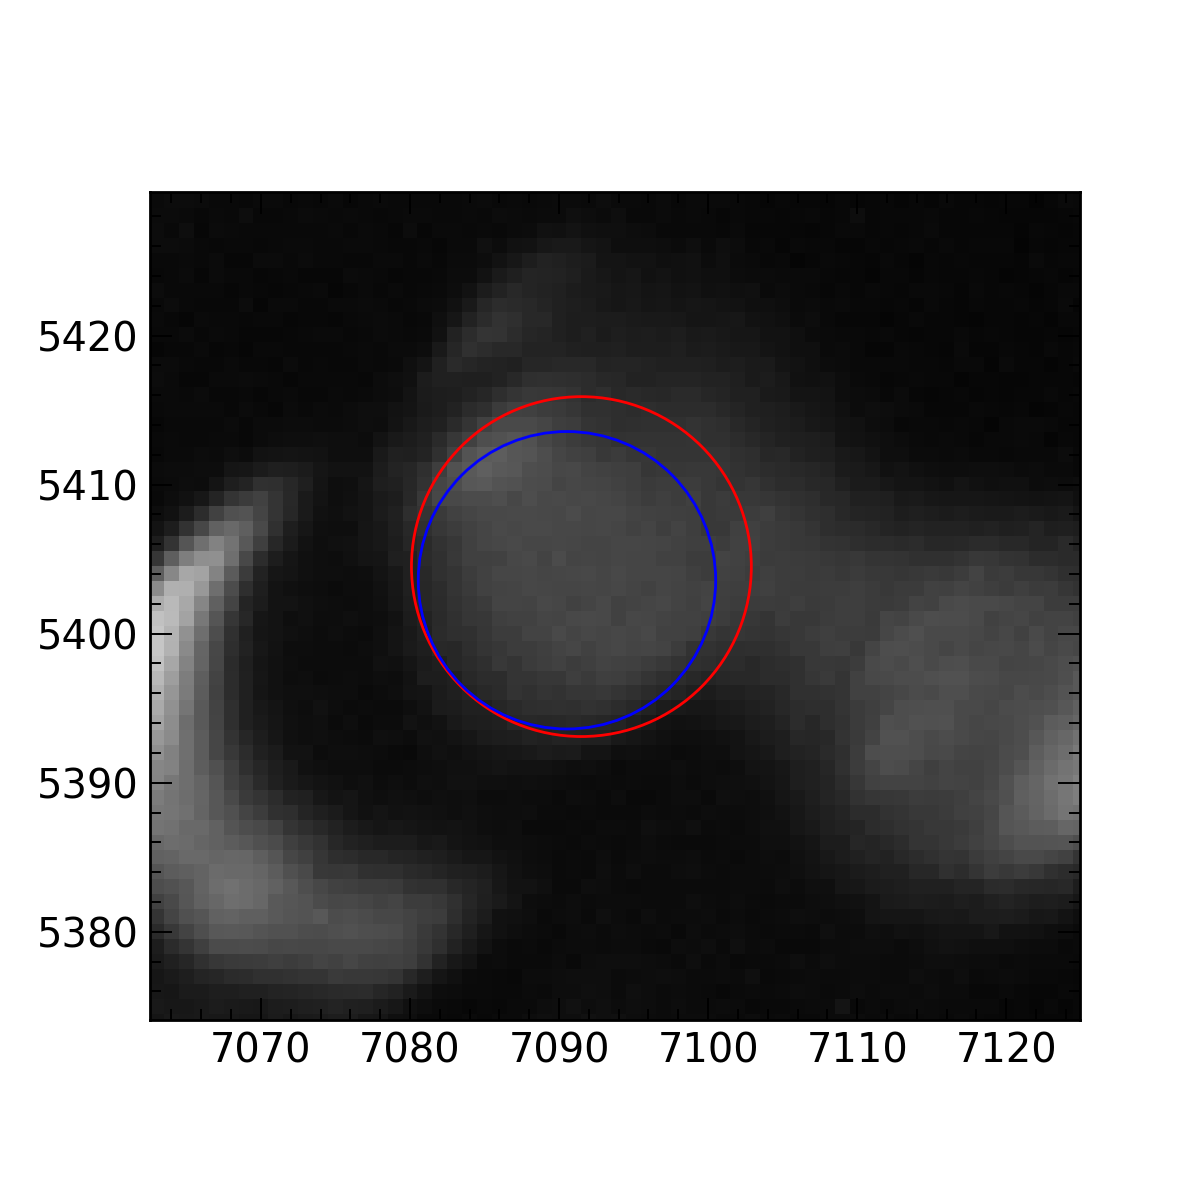

In [45]:
%matplotlib notebook
m, s = np.mean(data), np.std(data)
#m, s = 400, 200

fig, ax = plt.subplots(figsize=(6,6))

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
#im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for x,y,r in zip(df['x_meas'], df['y_meas'], df['r_meas']):
    c1 = plt.Circle((x,y), r, color='red', fill=False)
    ax.add_artist(c1)
for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
    c2 = plt.Circle((x,y), r, color='blue', fill=False)
    ax.add_artist(c2)

plt.show()

## get final affine matrix

In [41]:
%matplotlib notebook
import pandas as pd
import sep
import cv2
from copy import deepcopy

import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [43]:
fel=pd.read_csv('/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/dot_pos_final.txt', sep = '\s+')
fel[:5]

id        x_mm  y_mm            x            y           bb           cc
0   0   96.994843   0.0  5614.759176  2886.225955  5614.759277  2886.101562
1   1  103.923042   4.0  5695.685201  2932.765529  5695.393555  2932.880127
2   2  110.851250   8.0  5776.593112  2979.286068  5776.393066  2979.337891
3   3  117.779450  12.0  5857.156087  3025.757010  5857.078613  3025.395508
4   4  124.707657  16.0  5937.719843  3072.196818  5937.756348  3072.048340

In [42]:
filename = './results/dot_measurements_subaru_20210710_el90_rot+00_ave.csv'
df = pd.read_csv(filename)
df[:5]

id    x_dot    y_dot    r_dot
0  0.0  5144.74  3509.03  10.0297
1  1.0  5238.65  3560.32  10.0301
2  2.0  5332.56  3611.62  10.0301
3  3.0  5426.48  3662.92  10.0298
4  4.0  5520.38  3714.21  10.0291

In [48]:
## choose different points (should be spreaded over entire field)
id_sel = list(fel['id'])
x_mcs_sel = list(df['x_dot'])
y_mcs_sel = list(df['y_dot'])
x_pfi_sel = list(fel.loc[id_sel]['x_mm'])
y_pfi_sel = list(fel.loc[id_sel]['y_mm'])

In [50]:
pts1=np.zeros((1,len(id_sel),2))
pts2=np.zeros((1,len(id_sel),2))
pts1[0,:,0]=x_pfi_sel
pts1[0,:,1]=y_pfi_sel
pts2[0,:,0]=x_mcs_sel
pts2[0,:,1]=y_mcs_sel

afCoeff,inlier=cv2.estimateAffinePartial2D(pts1, pts2)
inlier=inlier.reshape(len(inlier))

M={}
M['affineCoeff'] = afCoeff
M['xTrans']=afCoeff[0,2]
M['yTrans']=afCoeff[1,2]
M['xScale']=np.sqrt(afCoeff[0,0]**2+afCoeff[0,1]**2)
M['yScale']=np.sqrt(afCoeff[1,0]**2+afCoeff[1,1]**2)
M['angle']=np.arctan2(afCoeff[1,0]/np.sqrt(afCoeff[0,0]**2+afCoeff[0,1]**2), afCoeff[1,1]/np.sqrt(afCoeff[1,0]**2+afCoeff[1,1]**2))

In [52]:
pts=np.zeros((1,len(fel),2))
pts[0,:,0]=fel['x_mm']
pts[0,:,1]=fel['y_mm']
afCor=cv2.transform(pts, M['affineCoeff'])
rx=afCor[0,:,0]
ry=afCor[0,:,1]

In [53]:
M

{'affineCoeff': array([[ 1.33469633e+01,  3.16097986e-01,  3.85043098e+03],
        [-3.16097986e-01,  1.33469633e+01,  3.53957594e+03]]),
 'xTrans': 3850.430981665831,
 'yTrans': 3539.575944584725,
 'xScale': 13.350705883678895,
 'yScale': 13.350705883678895,
 'angle': -0.023678712465273113}

In [55]:
file='/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/2021-07-10/PFSC22589000.fits'
f =pyfits.open(file)
data=f[1].data

<IPython.core.display.Javascript object>


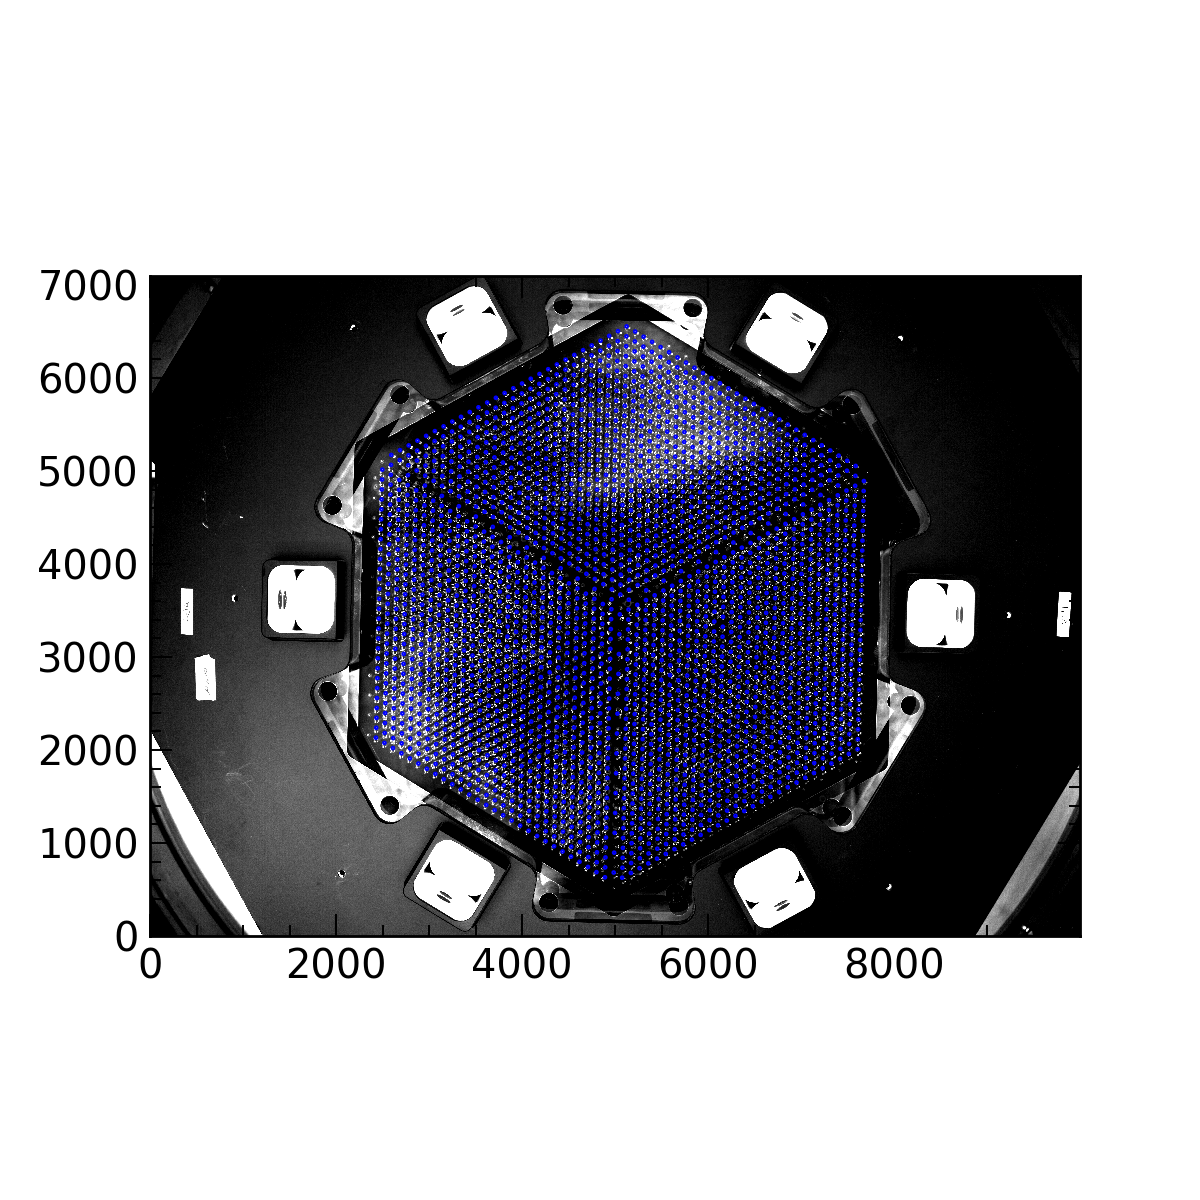

In [57]:
%matplotlib notebook

#m, s = np.mean(data), np.std(data)
m, s = 500, 200

fig, ax = plt.subplots(figsize=(6,6))

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for x,y in zip(rx, ry):
    c2 = plt.Circle((x,y), 10.0, color='blue', fill=False)
    ax.add_artist(c2)

plt.show()

## get final distortion matrix

In [58]:
%matplotlib notebook
import pandas as pd
import sep
import cv2
from copy import deepcopy

import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [59]:
fel=pd.read_csv('/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/dot_pos_final.txt', sep = '\s+')
fel[:5]

id        x_mm  y_mm            x            y           bb           cc
0   0   96.994843   0.0  5614.759176  2886.225955  5614.759277  2886.101562
1   1  103.923042   4.0  5695.685201  2932.765529  5695.393555  2932.880127
2   2  110.851250   8.0  5776.593112  2979.286068  5776.393066  2979.337891
3   3  117.779450  12.0  5857.156087  3025.757010  5857.078613  3025.395508
4   4  124.707657  16.0  5937.719843  3072.196818  5937.756348  3072.048340

In [60]:
filename = './results/dot_measurements_subaru_20210710_el90_rot+00_ave.csv'
df = pd.read_csv(filename)
df[:5]

id    x_dot    y_dot    r_dot
0  0.0  5144.74  3509.03  10.0297
1  1.0  5238.65  3560.32  10.0301
2  2.0  5332.56  3611.62  10.0301
3  3.0  5426.48  3662.92  10.0298
4  4.0  5520.38  3714.21  10.0291

In [61]:
pts0=np.zeros((1,len(fel),3))
pts0[0,:,0]=fel['x_mm']
pts0[0,:,1]=fel['y_mm']
pts0[0,:,2]=[0 for x in fel['x_mm']]
pts1=np.zeros((1,len(fel),3))
pts2=np.zeros((1,len(fel),2))
pts1[0,:,0]=fel['x_mm']
pts1[0,:,1]=fel['y_mm']
pts1[0,:,2]=[0 for x in fel['x_mm']]
pts2[0,:,0]=df['x_dot']
pts2[0,:,1]=df['y_dot']

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

In [62]:
for i in bad_idx:
    pts1 = np.delete(pts1, i, 1)
    pts2 = np.delete(pts2, i, 1)    

In [63]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)

In [64]:
## calculate dot position ##
for i in range(len(pts0)):
    imgpoints2, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

In [65]:
## calculate dot radius ##
pts0d = deepcopy(pts0)
pts0d[0,:,0] = pts0d[0,:,0] + 1.5

for i in range(len(pts0)):
    tmp1, _ = cv2.projectPoints(pts0[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)
for i in range(len(pts0d)):
    tmp2, _ = cv2.projectPoints(pts0d[i].astype(np.float32),rvecs[i], tvecs[i], mtx, dist)

dot_rad = (tmp2[:,0,0] - tmp1[:,0,0]) / 2.0

In [66]:
dot_pos = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_rad[:])])

In [74]:
mtx

array([[1.21876707e+04, 0.00000000e+00, 5.01658495e+03],
       [0.00000000e+00, 1.21863666e+04, 3.63191377e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [68]:
file='/work/PFS/pfi/data/ait_subaru_202107/dot_measurements/2021-07-10/PFSC22589000.fits'
f =pyfits.open(file)
data=f[1].data

<IPython.core.display.Javascript object>


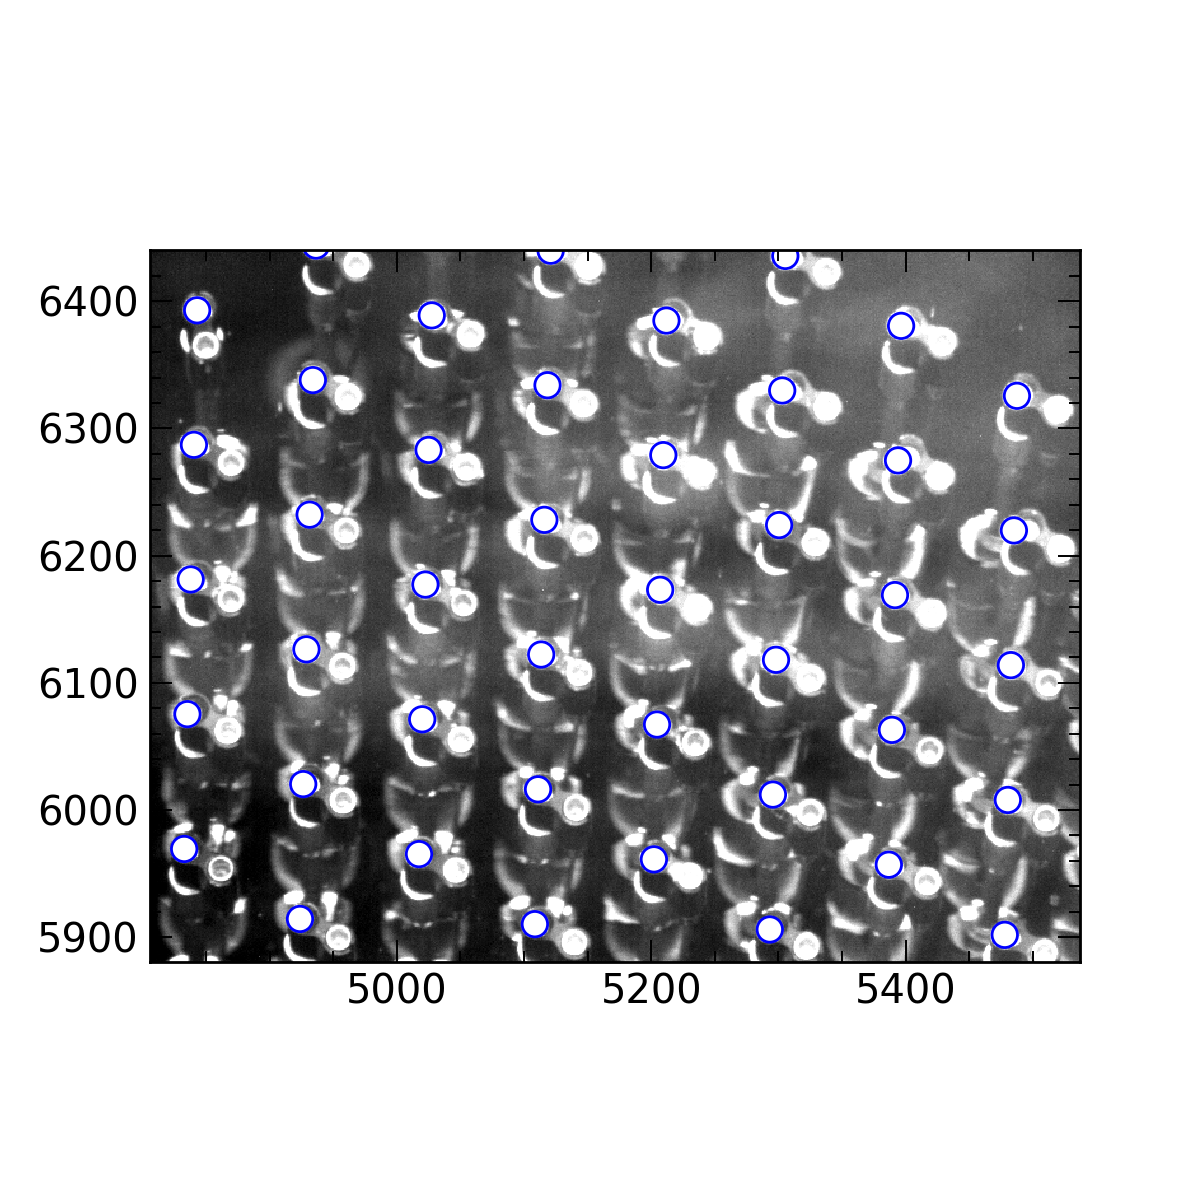

In [69]:
%matplotlib notebook

#m, s = np.mean(data), np.std(data)
m, s = 500, 200

fig, ax = plt.subplots(figsize=(6,6))

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for i,p in enumerate(dot_pos):
    c = plt.Circle((p[0], p[1]), p[2], color='blue', fill=False)
    ax.add_artist(c)

plt.show()

## below are junks

<IPython.core.display.Javascript object>


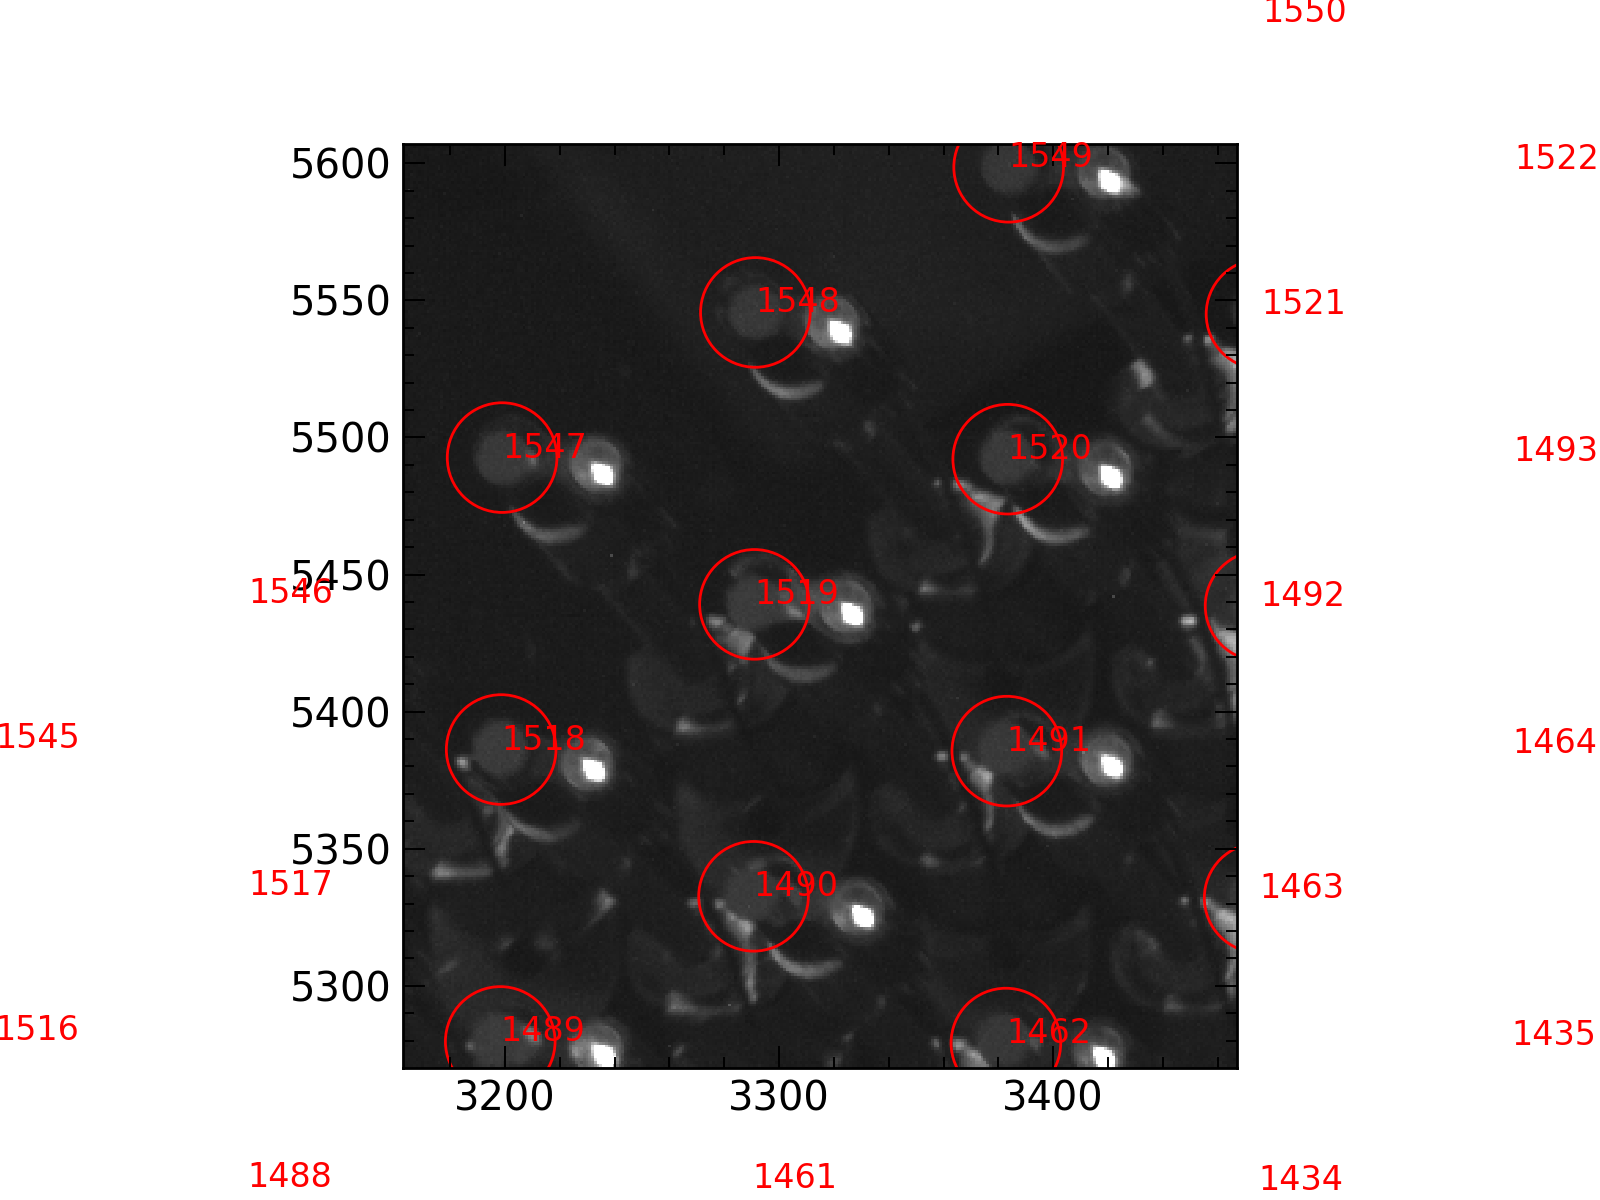

In [139]:
%matplotlib notebook
m, s = np.mean(data), np.std(data)

fig, ax = plt.subplots(figsize=(8,6))

im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')


for i in range(len(rx)):
    c = plt.Circle((rx[i], ry[i]), 20, color='red', fill=False)
    ax.add_artist(c)
    ax.text(rx[i], ry[i], '%d' % (fel['id'][i]), color='red')
    
plt.show()

In [140]:
bad_id = [1565, 1567, 1539, 1510, 819, 406, 1489, 1491]
bad_x = [4861, 5047, 5138, 5138, 5595, 6425, 3198, 3383]
bad_y = [6446, 6552, 6497, 6392, 4104, 2765, 5279, 5386]

In [151]:
dot_pos2_rev = deepcopy(dot_pos2)

In [152]:

for i,x,y in zip(bad_id, bad_x, bad_y):
    dot_pos2_rev[i,0] = x
    dot_pos2_rev[i,1] = y

array([[5130.24853516, 3517.08959961,    9.10000038],
       [5222.87255859, 3572.17553711,   11.39999962],
       [5317.49658203, 3625.26147461,   11.39999962],
       ...,
       [2920.39038086, 4802.21044922,   10.30000019],
       [2736.81884766, 4908.55371094,   10.        ],
       [2554.24731445, 5014.89746094,    9.60000038]])

<IPython.core.display.Javascript object>


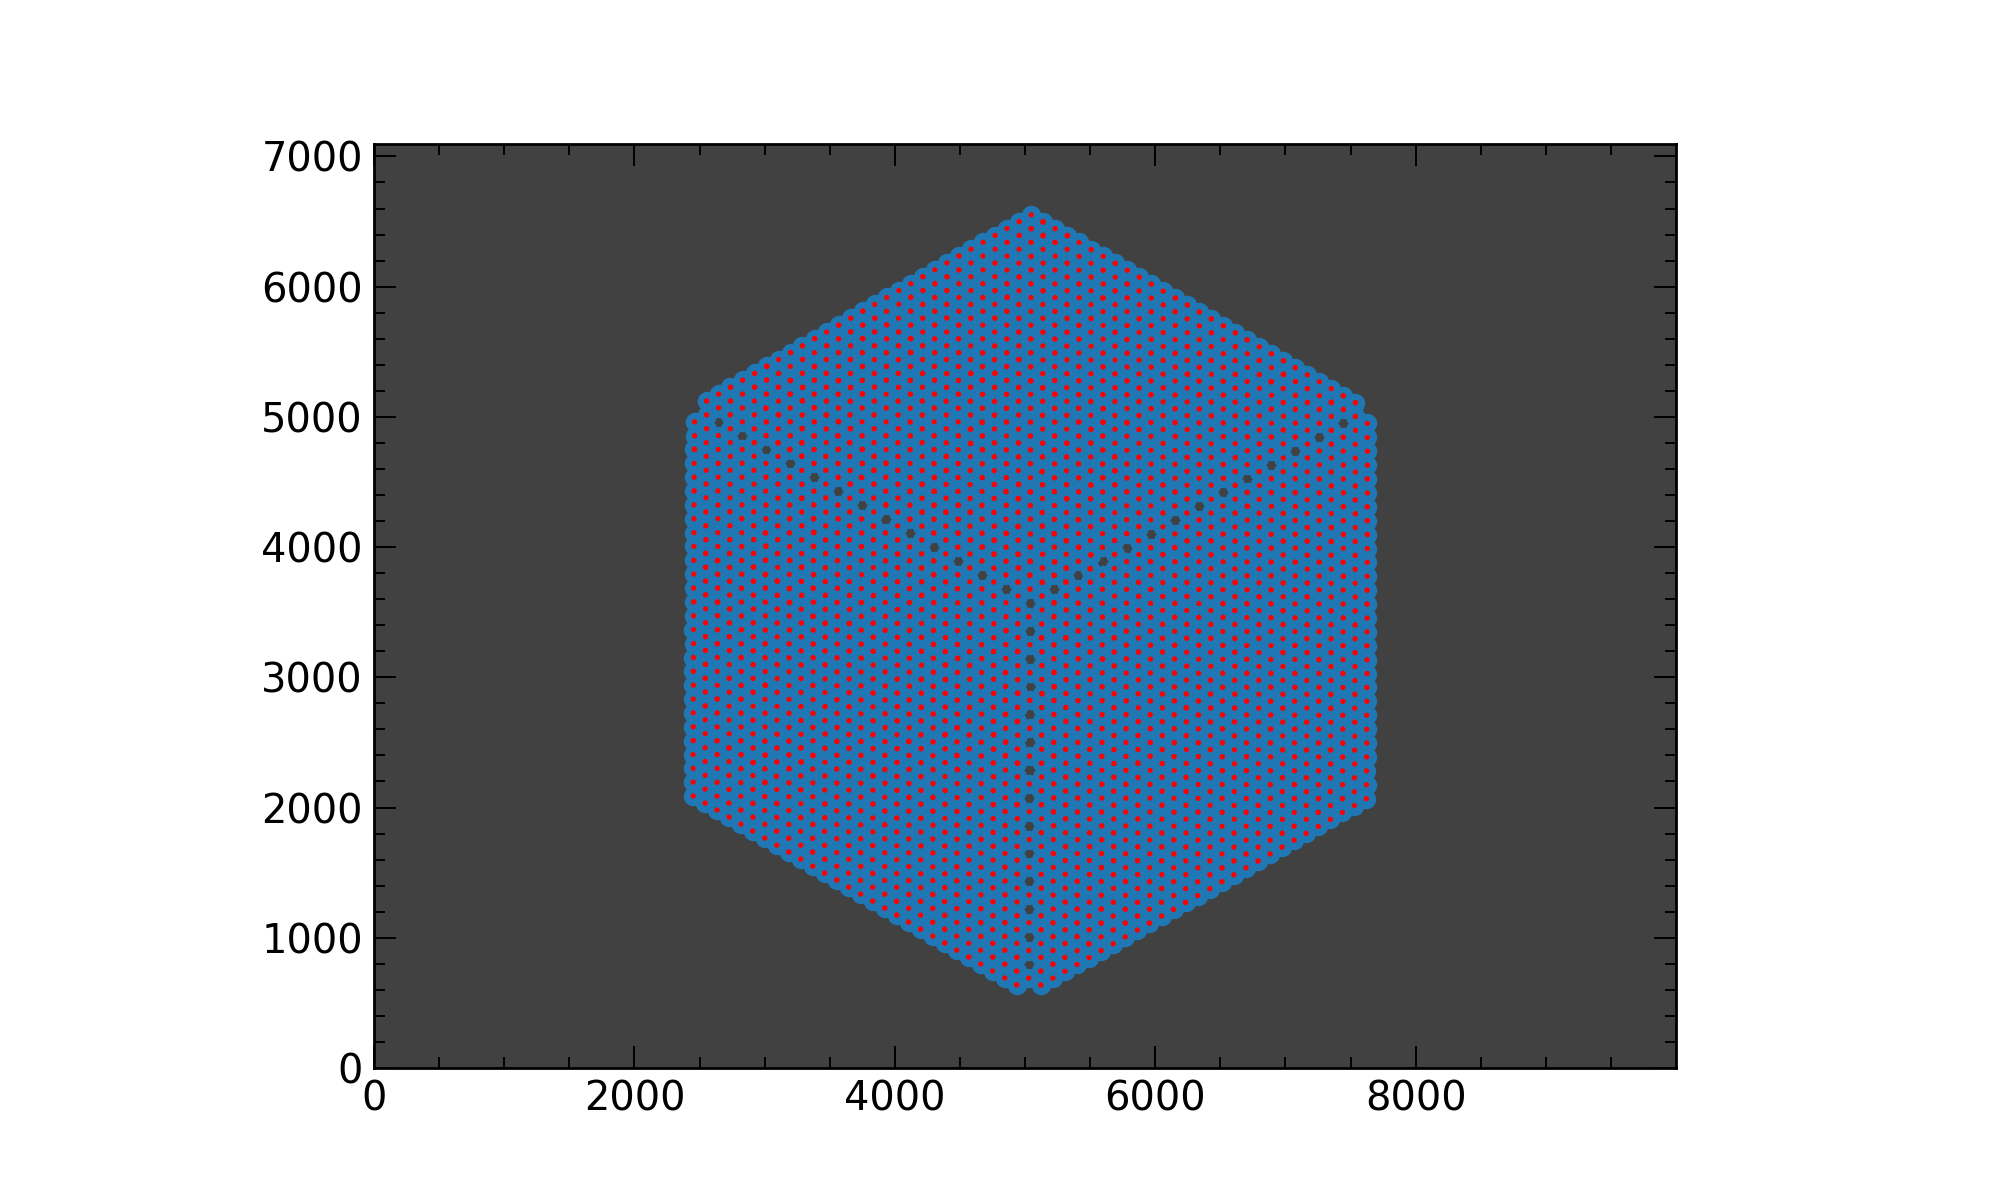

In [155]:
%matplotlib notebook
m, s = 400, 200

fig, ax = plt.subplots(figsize=(10,6))

im = ax.imshow(imag_new2, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for p in dot_pos2_rev:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
    
plt.show()

In [161]:
filename = 'dot_measurements_20210428_el90_rot00_v216417.csv'
np.savetxt(filename, dot_pos2_rev, delimiter=',', header='x,y,radius')

In [162]:
df = pd.read_csv(filename)

In [163]:
df

# x            y  radius
0     5130.248535  3517.089600     9.1
1     5222.872559  3572.175537    11.4
2     5317.496582  3625.261475    11.4
3     5409.120117  3677.347412    10.0
4     5501.744141  3730.433350    10.2
...           ...          ...     ...
2389  3285.533447  4588.523438     9.4
2390  3102.961914  4695.867188     9.1
2391  2920.390381  4802.210449    10.3
2392  2736.818848  4908.553711    10.0
2393  2554.247314  5014.897461     9.6

[2394 rows x 3 columns]

<IPython.core.display.Javascript object>


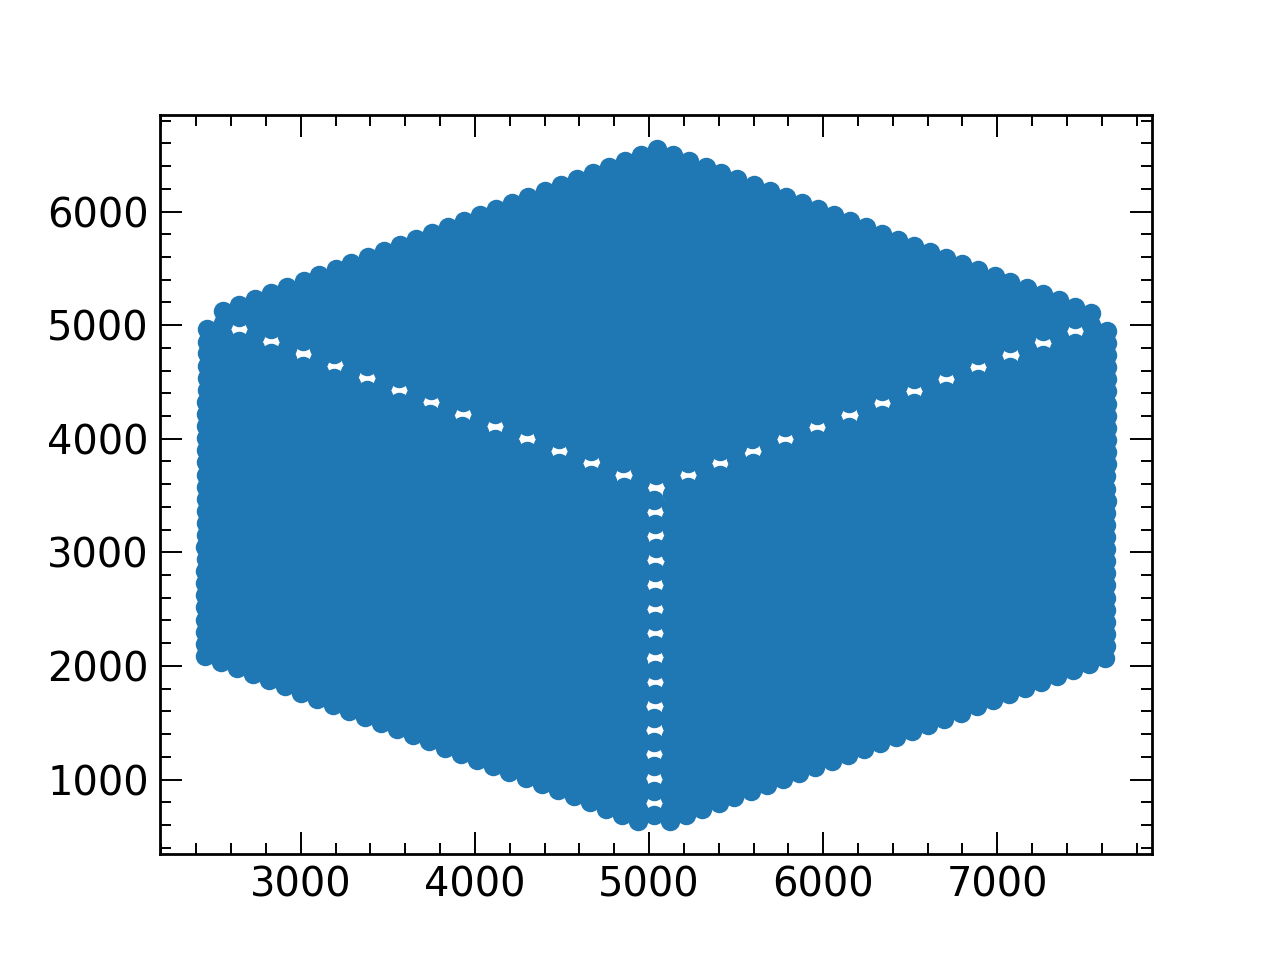

In [166]:
%matplotlib notebook

plt.scatter(df['# x'], df['y'])

In [239]:
dist_x = dot_pos[:,0] - rx
dist_y = dot_pos[:,1] - ry

In [244]:
dot_pos

array([[5128.53140525, 3517.5       ,   11.39999962],
       [5221.67646259, 3572.7       ,   10.30000019],
       [5319.82162101, 3632.9       ,   11.39999962],
       ...,
       [2919.04902494, 4804.3       ,   11.39999962],
       [2733.75891159, 4905.7       ,   11.39999962],
       [2554.46859475, 5013.1       ,   10.30000019]])

<IPython.core.display.Javascript object>


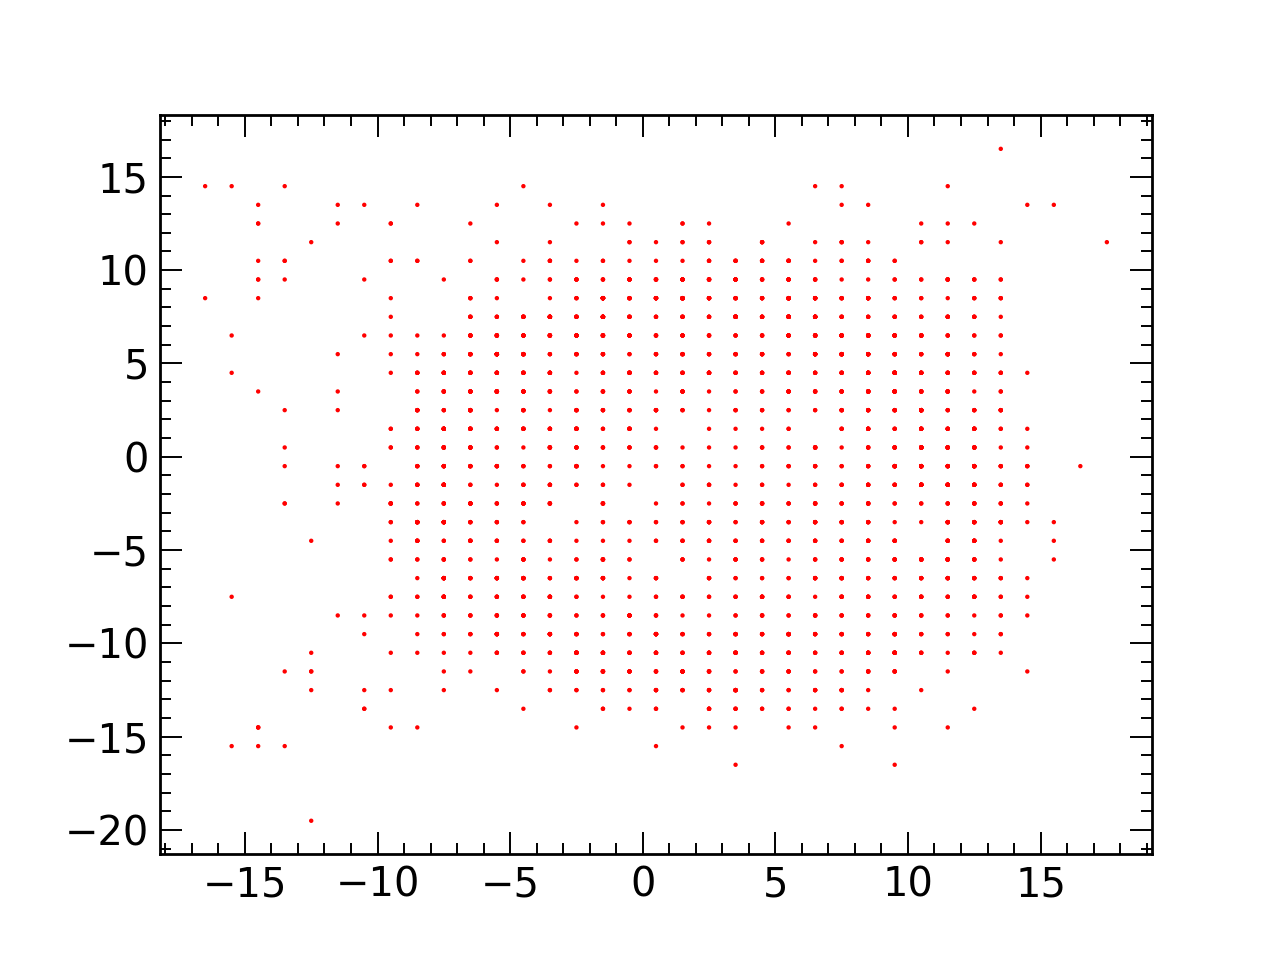

In [241]:
%matplotlib notebook

plt.scatter(dist_x, dist_y, marker='.', s=10, fc='red', ec='none')


In [227]:
dist = np.sqrt((dot_pos[:,0] - rx)**2 + (dot_pos[:,1] - ry)**2)

<IPython.core.display.Javascript object>


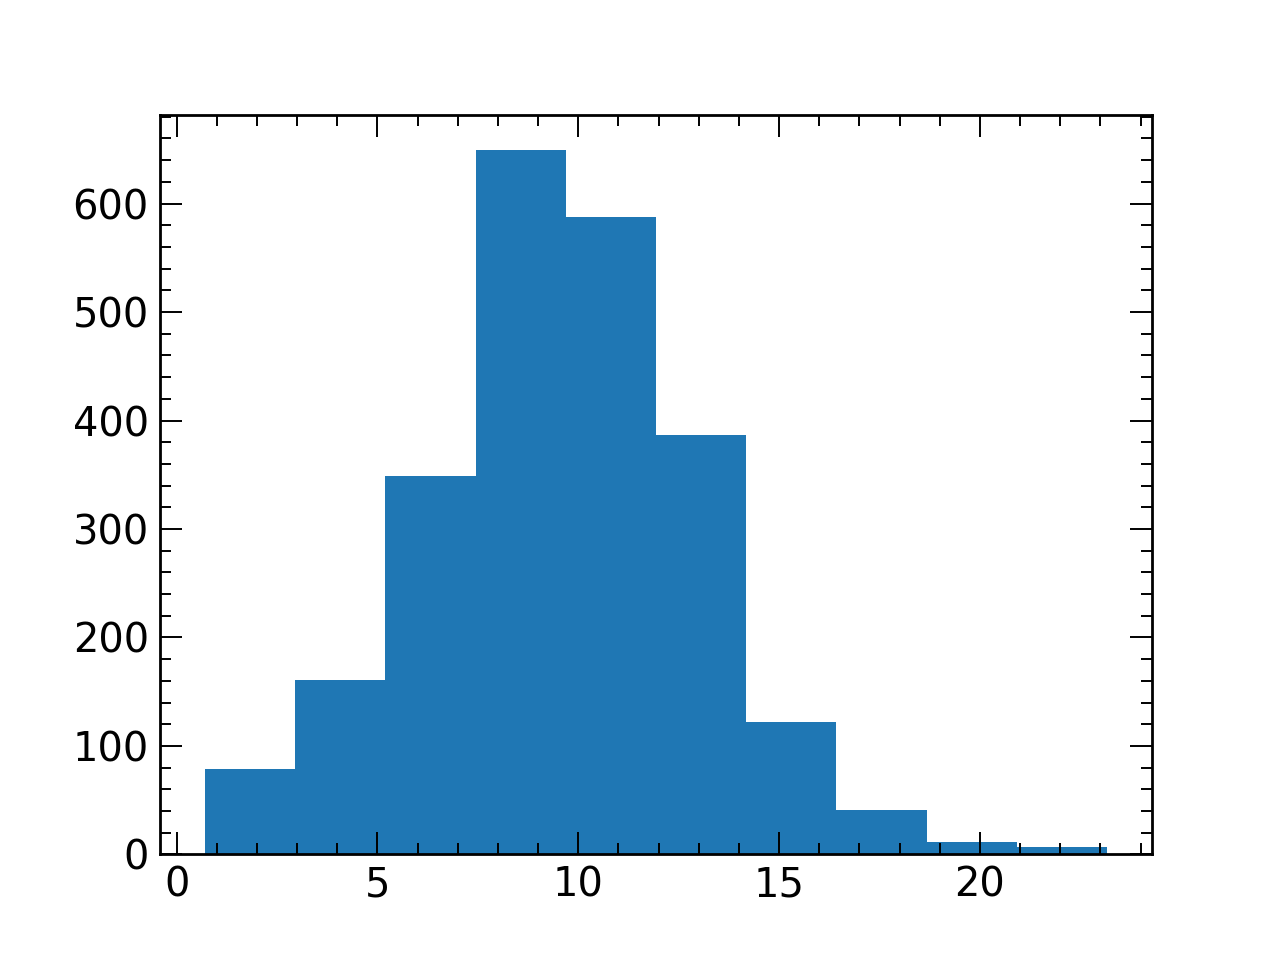

(array([ 79., 161., 349., 649., 588., 387., 122.,  41.,  11.,   7.]),
 array([ 0.70710678,  2.95264307,  5.19817935,  7.44371564,  9.68925193,
        11.93478821, 14.1803245 , 16.42586079, 18.67139707, 20.91693336,
        23.16246964]),
 <a list of 10 Patch objects>)

In [228]:
%matplotlib notebook

plt.hist(dist)

In [246]:
msk = dist > 20.

rx_new = deepcopy(rx)
ry_new = deepcopy(ry)
for i in range(len(rx)):
    if msk[i] != True:
        rx_new[i] = dot_pos[i,0]
        ry_new[i] = dot_pos[i,1]

<IPython.core.display.Javascript object>


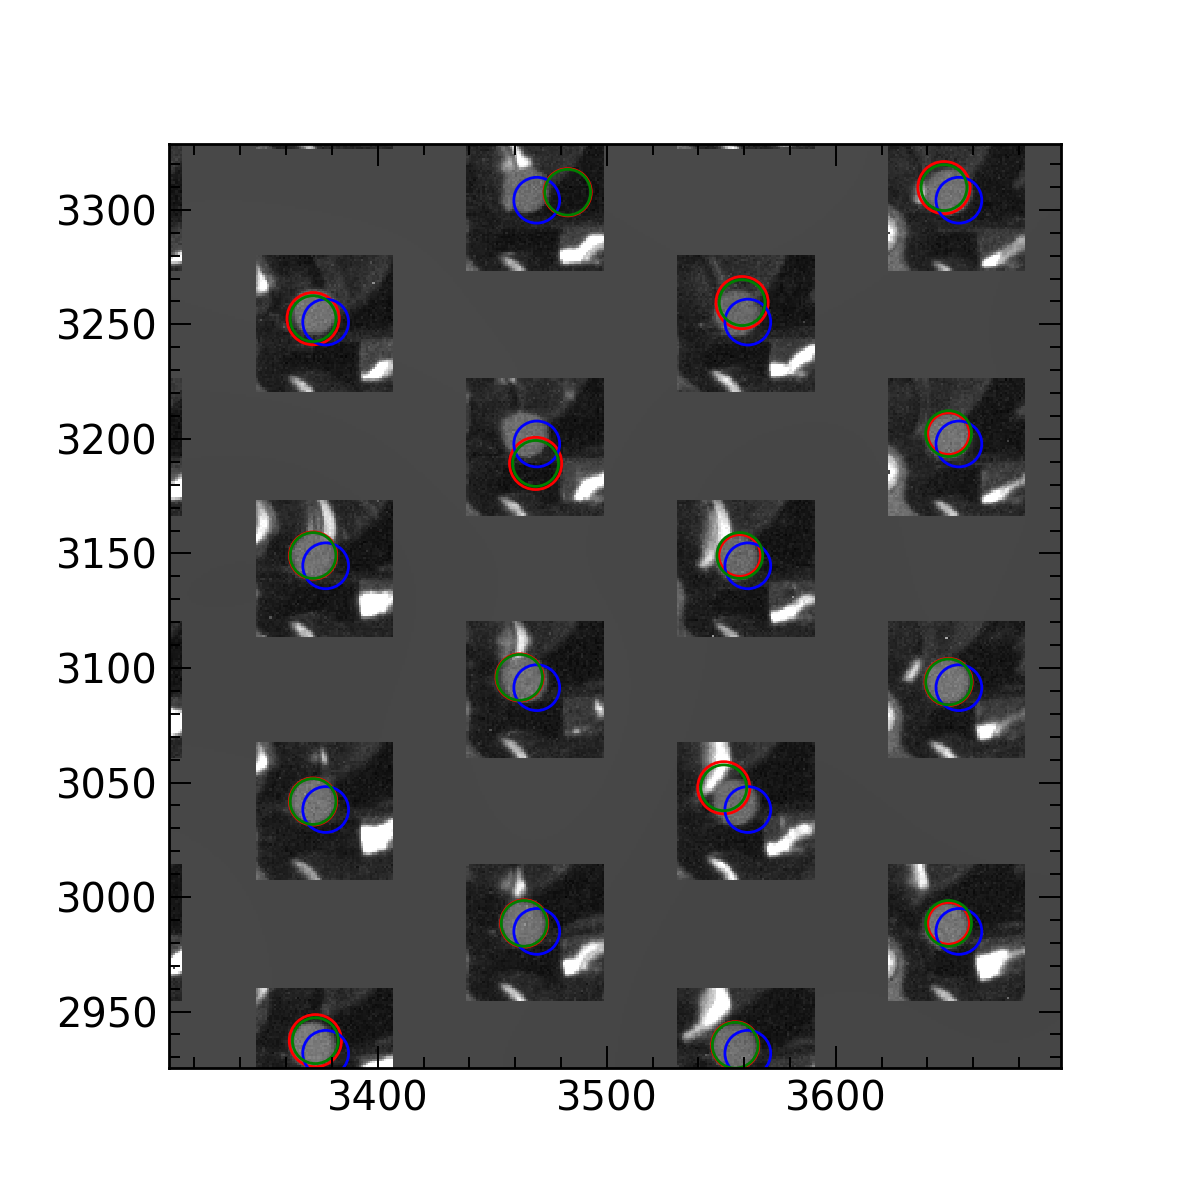

In [247]:
%matplotlib notebook
#m, s = np.mean(data), np.std(data)
m, s = 400, 200

fig, ax = plt.subplots(figsize=(6,6))

#im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
im = ax.imshow(imag_new_flt, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for p in dot_pos:
    c1 = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c1)
for x,y in zip(rx, ry):
    c2 = plt.Circle((x, y), 10, color='blue', fill=False)
    ax.add_artist(c2)
for x,y in zip(rx_new, ry_new):
    c3 = plt.Circle((x, y), 10, color='green', fill=False)
    ax.add_artist(c3)
    
plt.show()

In [237]:
i = 1

reg=25

dot_pos2 = []
for i in range(len(rx_new)):
    #data_sub=data[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
    data_sub=imag_new_flt[int(ry_new[i]-reg):int(ry_new[i]+reg),int(rx_new[i]-reg):int(rx_new[i]+reg)]
    imag_sub=deepcopy(data_sub)
    #imag_sub[imag_sub < 300]=0
    #imag_sub[imag_sub > 900]=0

    #circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 55,
    #                               param1=230,param2=9,minRadius=5,maxRadius=10)
    circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                               param1=300,param2=9,minRadius=6,maxRadius=12)

    if circles is not None:
        dot_x = rx_new[i]+circles[0,0,0]-reg
        dot_y = ry_new[i]+circles[0,0,1]-reg
        dot_r = circles[0,0,2]
        dot_pos2.append((dot_x, dot_y, dot_r))
    else:
        print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')

<IPython.core.display.Javascript object>


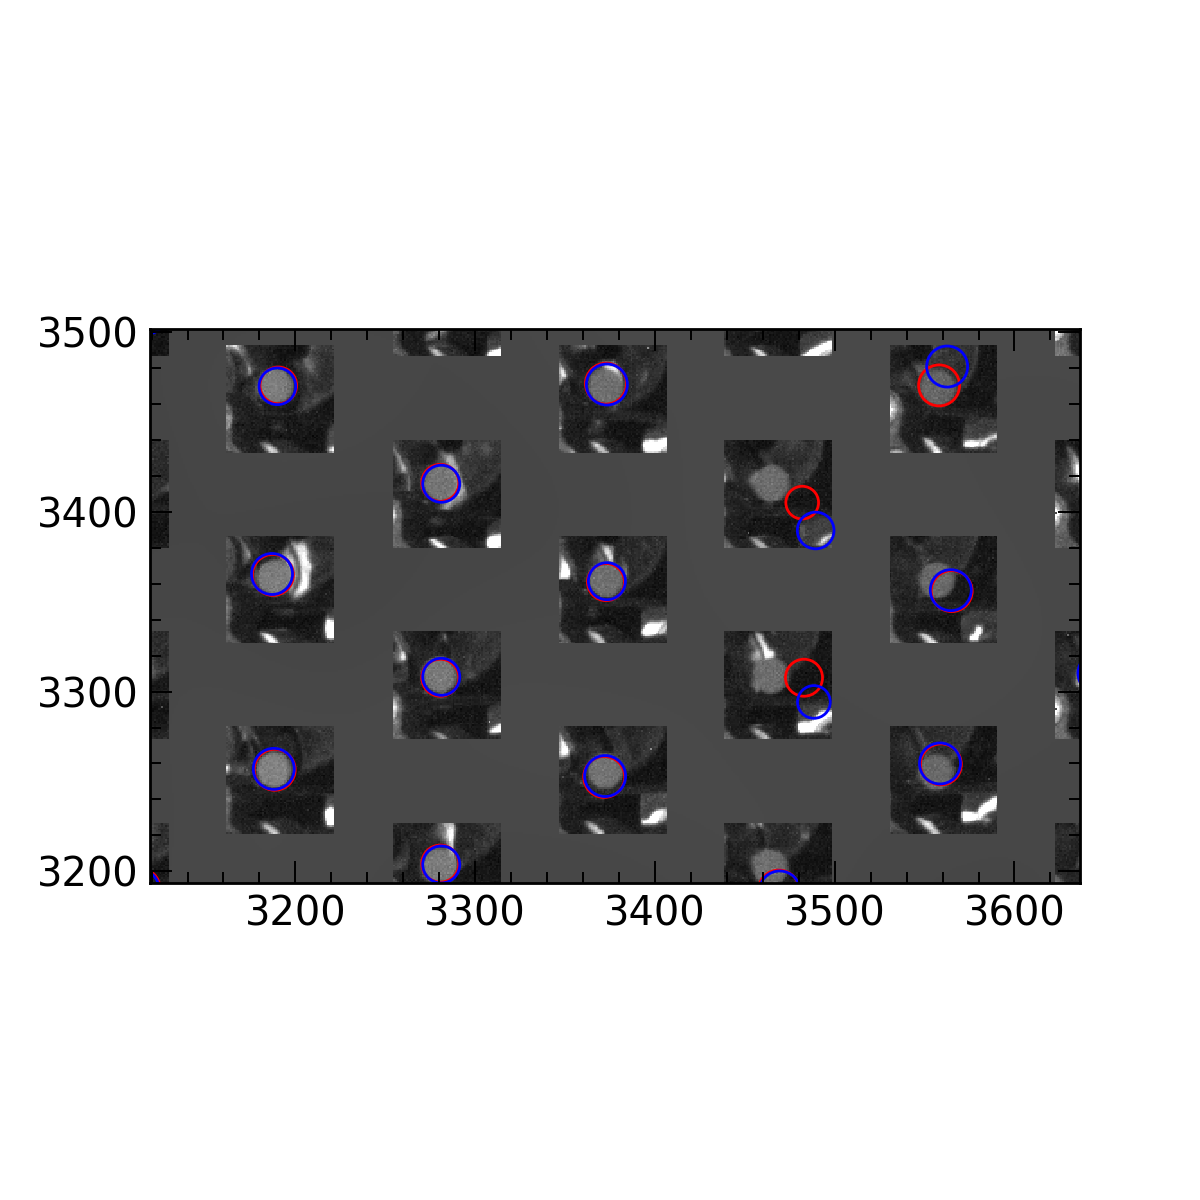

In [238]:
%matplotlib notebook
#m, s = np.mean(data), np.std(data)
m, s = 400, 200

fig, ax = plt.subplots(figsize=(6,6))

#im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')
im = ax.imshow(imag_new_flt, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')

for p in dot_pos:
    c = plt.Circle((p[0], p[1]), p[2], color='red', fill=False)
    ax.add_artist(c)
for p in dot_pos2:
    c = plt.Circle((p[0], p[1]), p[2], color='blue', fill=False)
    ax.add_artist(c)
    
plt.show()

In [214]:
i=1683

reg=30

data_sub=imag_new_flt[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
imag_sub=deepcopy(data_sub)
#imag_sub[imag_sub < 500]=0
imag_sub[imag_sub > 1200]=0


#circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 55,
#                               param1=300,param2=10,minRadius=6,maxRadius=12)
circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                               param1=300,param2=5,minRadius=6,maxRadius=12)

circles

array([[[44.5, 13.5, 11.4]]], dtype=float32)

<IPython.core.display.Javascript object>


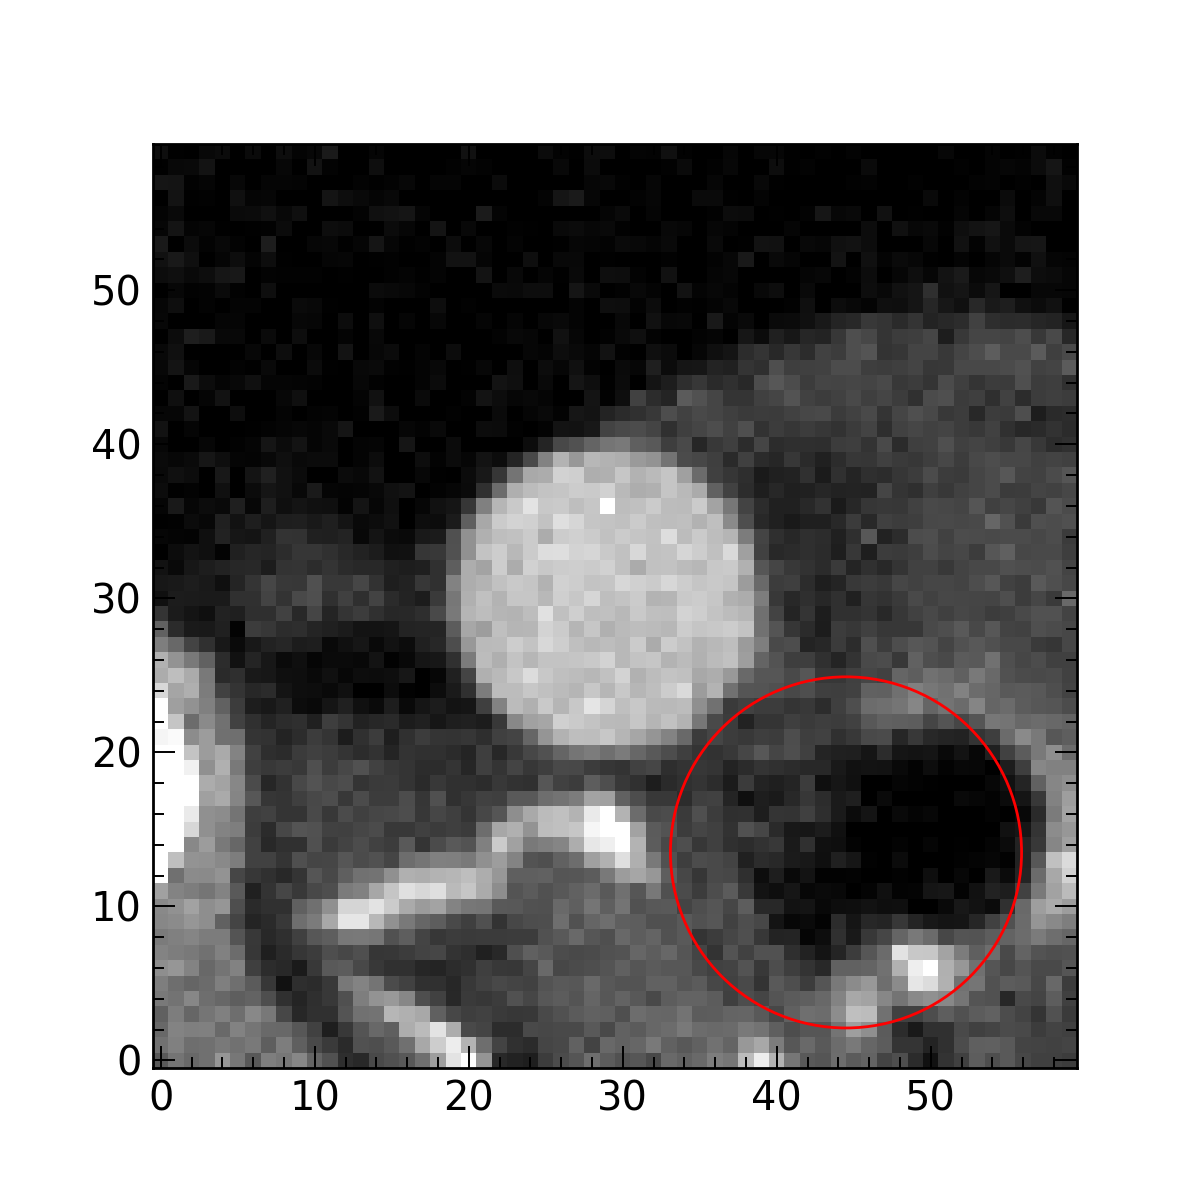

In [215]:
%matplotlib notebook
m, s = np.mean(data_sub), np.std(data_sub)

fig, ax = plt.subplots(figsize=(6,6))

im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+3*s, origin='lower')


for i in circles[0,:]:
    
    c = plt.Circle((i[0], i[1]), i[2], color='red', fill=False)
    ax.add_artist(c)

    
plt.show()

In [51]:
np.median(data_sub)

461.5